<div class="usecase-title">Entertainment Location Projections</div>

<div class="usecase-authors"><b>Updated (2024): Te' Claire. Original Authors (2023): Barkha Javed, Jack Pham </div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>
</div>

 <div class="usecase-section-header">Outline</div>

##### Datasets
##### Datasets
* Blocks For Census of Land use and employment clue
##### Link: https://data.melbourne.vic.gov.au/explore/dataset/blocks-for-census-of-land-use-and-employment-clue/information/?location=12,-37.81306,144.94413&basemap=jawg.light
##### blocks-for-census-of-land-use-and-employment-clue
<br>

* Bar, tavern, pub patron capacity
##### Link: https://data.melbourne.vic.gov.au/explore/dataset/bars-and-pubs-with-patron-capacity/table/?refine.census_year=2022
##### bars-and-pubs-with-patron-capacity
<br>

* Cafe, restaurant, bistro seats
##### Link: https://data.melbourne.vic.gov.au/explore/dataset/cafes-and-restaurants-with-seating-capacity/table/?refine.census_year=2022
##### cafes-and-restaurants-with-seating-capacity
<br>

* City Activities and Planned Works
##### Link: https://data.melbourne.vic.gov.au/explore/dataset/city-activities-and-planned-works/information/?disjunctive.classification&disjunctive.small_area
##### city-activities-and-planned-works
<br>

* Hourly pedestrian counts from sensors located across the city
##### Link: https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/
##### pedestrian-counting-system-monthly-counts-per-hour
<br>


* COM population forecasts by small area for 2020-2040
##### Link: https://data.melbourne.vic.gov.au/explore/dataset/city-of-melbourne-population-forecasts-by-small-area-2020-2040/information/
##### city-of-melbourne-population-forecasts-by-small-area-2020-2040




###### User Story

**As a City of Melbourne council worker, I want to visualise and provide statistics on upcoming activities and planned works in entertainment and leisure, so that I can understand impact for my local area.**

**As a City of Melbourne Council worker, I want to see which entertainment locations are projected as growth areas.**

#### Set up

In [1]:
#Libraries to be installed
##!pip -q is to give less output
!pip -q install seaborn
!pip -q install pandas
!pip -q install matplotlib
!pip -q install numpy
!pip -q install nbconvert
!pip -q install keyboard
!pip -q install geopandas
!pip -q install requests
!pip -q install folium
!pip -q install statsmodels
!pip -q install tqdm
!pip -q install scikit-learn
!pip -q install pendulum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 7.2 MB/s eta 0:00:00


In [2]:
from io import StringIO
import requests

In [3]:
#load libraries
import os
import io
import time
import keyboard
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import requests
import zipfile

import numpy as np
import pandas as pd

from urllib.request import urlopen
import json
from pandas import json_normalize


import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from IPython.core.display import display, HTML
import geopandas as gpd


import plotly.graph_objects as go
import plotly.express as px
from shapely.geometry import Polygon, shape, Point, box
from shapely.ops import unary_union
from shapely.wkt import loads

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')

from pylab import rcParams
rcParams['figure.figsize'] = 8,4


In [4]:
import warnings
warnings.filterwarnings("ignore")

!pip install tqdm # Progress bar
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 2.9 MB/s eta 0:00:00


In [5]:
#set default values
this_decade = (pd.Timestamp.today().year)-10
this_year = pd.Timestamp.today().year
y3 = (pd.Timestamp.today().year)-3
y2 = (pd.Timestamp.today().year)-2
y1 = (pd.Timestamp.today().year)-1


#Replacement for socrata
domain = 'https://data.melbourne.vic.gov.au/explore/dataset/'
baseurl = '/download/?format=json&timezone=Australia/Sydney&lang=en'
basegeourl='/download/?format=geojson&timezone=Australia/Sydney&lang=en'

In [6]:
# Define the company colors
color_d = ['#08af64', '#14a38e', '#0f9295', '#056b8a', '#121212'] #Dark theme
color_d_extend = ['#00918D', '#007E87', '#008883', '#0C5D70', '#51C293', '#008C9E', '#08af64', '#14a38e', '#0f9295', '#056b8a', '#121212']
color_night = ['#121212']
color_white = ['#B6B8D6']
color_l = ['#2af598', '#22e4ac', '#1bd7bb', '#14c9cb', '#0fbed8', '#08b3e5'] #Light theme
color_median = ['#9f1b04', '#7f10d0', '#cc8400', '#e480a1', '#4a71c7']

In [7]:
# API Key
from google.colab import drive
drive.mount('/content/drive')
with open('/content/drive/My Drive/SIT378/h.txt', 'r') as file:
    api_key = file.read().strip()

import os
api_key = os.getenv(api_key)

Mounted at /content/drive


In [8]:
# Upload data
# Download datasets
def download_dataset(api_key, dataset_id, base_url='https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'):
    format = 'csv'
    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        'api_key': api_key
    }

    with requests.get(url, params=params, stream=True) as response:
        if response.status_code == 200:
            total_size = int(response.headers.get('content-length', 0))
            chunk_size = 1024  # 1KB per chunk
            progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=f"Downloading {dataset_id}")

            content = bytearray()
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:  # filter out keep-alive new chunks
                    content.extend(chunk)
                    progress_bar.update(len(chunk))

            progress_bar.close()
            data = pd.read_csv(StringIO(content.decode('utf-8')), delimiter=';')
            return data
        else:
            print(f'Request failed with status code {response.status_code}')
            return None

# Dataset IDs
dataset_ids = [
    'blocks-for-census-of-land-use-and-employment-clue',
    'bars-and-pubs-with-patron-capacity',
    'pedestrian-counting-system-monthly-counts-per-hour',
    'cafes-and-restaurants-with-seating-capacity'
]

# Initialize dictionary to hold the datasets
datasets = {}

# Download each dataset with a progress bar
for dataset_id in dataset_ids:
    datasets[dataset_id] = download_dataset(api_key, dataset_id)
    if datasets[dataset_id] is not None:
        print(f"{dataset_id} downloaded successfully.")


blocks-for-census-of-land-use-and-employment-clue downloaded successfully.


bars-and-pubs-with-patron-capacity downloaded successfully.


pedestrian-counting-system-monthly-counts-per-hour downloaded successfully.


cafes-and-restaurants-with-seating-capacity downloaded successfully.


#### View Dataset

In [9]:
# blocks-for-census-of-land-use-and-employment-clue
print(datasets['blocks-for-census-of-land-use-and-employment-clue'].head())

                              geo_point_2d  \
0   -37.82296169692379, 144.95049282288122   
1   -37.78537422996195, 144.94085920366408   
2  -37.777687358375964, 144.94600024715058   
3  -37.796701447217345, 144.94361235073427   
4   -37.79293972627454, 144.94371829763847   

                                           geo_shape  block_id  \
0  {"coordinates": [[[144.9479230372, -37.8233694...      1112   
1  {"coordinates": [[[144.9426153438, -37.7866287...       927   
2  {"coordinates": [[[144.9425926939, -37.7787229...       929   
3  {"coordinates": [[[144.9447165759, -37.7961286...       318   
4  {"coordinates": [[[144.9453910459, -37.7925266...       302   

         clue_area  
0        Docklands  
1        Parkville  
2        Parkville  
3  North Melbourne  
4  North Melbourne  


In [10]:
# bars-and-pubs-with-patron-capacity
print(datasets['bars-and-pubs-with-patron-capacity'].head())

   census_year  block_id  property_id  base_property_id  \
0         2002        11       108972            108972   
1         2002        14       103172            103172   
2         2002        15       103944            103944   
3         2002        16       103938            103938   
4         2002        17       103925            103925   

                        building_address  clue_small_area     trading_name  \
0    10-22 Spencer Street MELBOURNE 3000  Melbourne (CBD)    Explorers Inn   
1  31-39 Elizabeth Street MELBOURNE 3000  Melbourne (CBD)  Connells Tavern   
2   277-279 Flinders Lane MELBOURNE 3000  Melbourne (CBD)         De Biers   
3       187 Flinders Lane MELBOURNE 3000  Melbourne (CBD)    Adelphi Hotel   
4   121-123 Flinders Lane MELBOURNE 3000  Melbourne (CBD)           Velour   

                                    business_address  number_of_patrons  \
0                10-22 Spencer Street MELBOURNE 3000                 50   
1                 35 Eliza

In [11]:
# pedestrian-counting-system-monthly-counts-per-hour
print(datasets['pedestrian-counting-system-monthly-counts-per-hour'].head())

  sensor_name                  timestamp  locationid  direction_1  \
0    SprFli_T  2023-04-24T21:00:00+00:00          75           36   
1    SprFli_T  2023-04-25T00:00:00+00:00          75           28   
2    SprFli_T  2023-04-25T01:00:00+00:00          75           63   
3    SprFli_T  2023-04-25T02:00:00+00:00          75           85   
4    SprFli_T  2023-04-25T08:00:00+00:00          75          365   

   direction_2  total_of_directions                    location  
0           17                   53  -37.81515276, 144.97467661  
1           50                   78  -37.81515276, 144.97467661  
2           63                  126  -37.81515276, 144.97467661  
3           89                  174  -37.81515276, 144.97467661  
4           59                  424  -37.81515276, 144.97467661  


In [12]:
# cafes-and-restaurants-with-seating-capacity
print(datasets['cafes-and-restaurants-with-seating-capacity'].head())

   census_year  block_id  property_id  base_property_id  \
0         2017         6       578324            573333   
1         2017         6       578324            573333   
2         2017        11       103957            103957   
3         2017        11       103957            103957   
4         2017        11       103985            103985   

                         building_address  clue_small_area  \
0        2 Swanston Street MELBOURNE 3000  Melbourne (CBD)   
1        2 Swanston Street MELBOURNE 3000  Melbourne (CBD)   
2    517-537 Flinders Lane MELBOURNE 3000  Melbourne (CBD)   
3    517-537 Flinders Lane MELBOURNE 3000  Melbourne (CBD)   
4  562-564 Flinders Street MELBOURNE 3000  Melbourne (CBD)   

            trading_name                                   business_address  \
0        Transport Hotel  Tenancy 29, Ground , 2 Swanston Street MELBOUR...   
1        Transport Hotel  Tenancy 29, Ground , 2 Swanston Street MELBOUR...   
2  Altius Coffee Brewers   Shop , G

In [13]:
# View number of records
for dataset_id, df in datasets.items():
    if df is not None:
        num_records = df.shape[0]  # number of row        print(f"{dataset_id} has {num_records} records.")

#### Individual datafreams
- seating_capacity_cafes : datasets['cafes-and-restaurants-with-seating-capacity']
- ped_count_hour : ['pedestrian-counting-system-monthly-counts-per-hour']
- employment-clue : ['blocks-for-census-of-land-use-and-employment-clue']
- bars-and-pubs : ['bars-and-pubs-with-patron-capacity']


In [15]:
# Pull DataFrame
df_btp_capacity = datasets['cafes-and-restaurants-with-seating-capacity']

# Column groups and types
integer_columns = ['census_year', 'block_id', 'property_id', 'base_property_id', 'number_of_seats']
str_columns = ['building_address', 'clue_small_area', 'trading_name']
float_columns = ['longitude', 'latitude']
df_btp_capacity[integer_columns] = df_btp_capacity[integer_columns].astype(int)
df_btp_capacity[float_columns] = df_btp_capacity[float_columns].astype(float)
df_btp_capacity[str_columns] = df_btp_capacity[str_columns].astype(str)

# Add a column for grouping
df_btp_capacity['category'] = 'Pubs, Taverns and Bars'

# Current year & start of the past decade
current_year = datetime.now().year
this_decade_start = current_year - 10
df_btp_capacity = df_btp_capacity.query("census_year >= @this_decade_start")
seating_capacity_cafes = df_btp_capacity.copy()

seating_capacity_cafes.info()
seating_capacity_cafes.head()

<class 'pandas.core.frame.DataFrame'>
Index: 30455 entries, 0 to 60054
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   census_year                   30455 non-null  int64  
 1   block_id                      30455 non-null  int64  
 2   property_id                   30455 non-null  int64  
 3   base_property_id              30455 non-null  int64  
 4   building_address              30455 non-null  object 
 5   clue_small_area               30455 non-null  object 
 6   trading_name                  30455 non-null  object 
 7   business_address              30455 non-null  object 
 8   industry_anzsic4_code         30455 non-null  int64  
 9   industry_anzsic4_description  30455 non-null  object 
 10  seating_type                  30455 non-null  object 
 11  number_of_seats               30455 non-null  int64  
 12  longitude                     30053 non-null  float64
 13  latitu

,census_year,block_id,property_id,base_property_id,building_address,clue_small_area,trading_name,business_address,industry_anzsic4_code,industry_anzsic4_description,seating_type,number_of_seats,longitude,latitude,location,category
0,2017,6,578324,573333,2 Swanston Street MELBOURNE 3000,Melbourne (CBD),Transport Hotel,"Tenancy 29, Ground , 2 Swanston Street MELBOUR...",4520,"Pubs, Taverns and Bars",Seats - Indoor,230,144.969942,-37.817778,"-37.817777826050005, 144.96994164279243","Pubs, Taverns and Bars"
1,2017,6,578324,573333,2 Swanston Street MELBOURNE 3000,Melbourne (CBD),Transport Hotel,"Tenancy 29, Ground , 2 Swanston Street MELBOUR...",4520,"Pubs, Taverns and Bars",Seats - Outdoor,120,144.969942,-37.817778,"-37.817777826050005, 144.96994164279243","Pubs, Taverns and Bars"
2,2017,11,103957,103957,517-537 Flinders Lane MELBOURNE 3000,Melbourne (CBD),Altius Coffee Brewers,"Shop , Ground , 517 Flinders Lane MELBOURNE 3000",4512,Takeaway Food Services,Seats - Outdoor,4,144.956486,-37.819875,"-37.819875445799994, 144.95648638781466","Pubs, Taverns and Bars"
3,2017,11,103957,103957,517-537 Flinders Lane MELBOURNE 3000,Melbourne (CBD),Five & Dime Bagel,16 Flinders Lane MELBOURNE 3000,1174,Bakery Product Manufacturing (Non-factory based),Seats - Indoor,14,144.956486,-37.819875,"-37.819875445799994, 144.95648638781466","Pubs, Taverns and Bars"
4,2017,11,103985,103985,562-564 Flinders Street MELBOURNE 3000,Melbourne (CBD),YHA Melbourne Central,562-564 Flinders Street MELBOURNE 3000,4400,Accommodation,Seats - Indoor,43,144.955635,-37.820595,"-37.82059511593975, 144.9556348088","Pubs, Taverns and Bars"


#### Pre-process data
- create datasets

In [16]:
# Date time set
# no date/time, blocks-for-census-of-land-use-and-employment-clue
# year value only, bars-and-pubs-with-patron-capacity and cafes-and-restaurants-with-seating-capacity
datasets['pedestrian-counting-system-monthly-counts-per-hour']['timestamp'] = pd.to_datetime(datasets['pedestrian-counting-system-monthly-counts-per-hour']['timestamp'])
ped_count_hour = datasets['pedestrian-counting-system-monthly-counts-per-hour']

ped_count_hour.info()
ped_count_hour.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549976 entries, 0 to 549975
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   sensor_name          549976 non-null  object             
 1   timestamp            549976 non-null  datetime64[ns, UTC]
 2   locationid           549976 non-null  int64              
 3   direction_1          549976 non-null  int64              
 4   direction_2          549976 non-null  int64              
 5   total_of_directions  549976 non-null  int64              
 6   location             549976 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(4), object(2)
memory usage: 29.4+ MB


,sensor_name,timestamp,locationid,direction_1,direction_2,total_of_directions,location
0,SprFli_T,2023-04-24 21:00:00+00:00,75,36,17,53,"-37.81515276, 144.97467661"
1,SprFli_T,2023-04-25 00:00:00+00:00,75,28,50,78,"-37.81515276, 144.97467661"
2,SprFli_T,2023-04-25 01:00:00+00:00,75,63,63,126,"-37.81515276, 144.97467661"
3,SprFli_T,2023-04-25 02:00:00+00:00,75,85,89,174,"-37.81515276, 144.97467661"
4,SprFli_T,2023-04-25 08:00:00+00:00,75,365,59,424,"-37.81515276, 144.97467661"


In [44]:
ped_count_hour.describe()

,locationid,direction_1,direction_2,total_of_directions
count,549976.000000,549976.000000,549976.000000,549976.000000
mean,53.513222,211.134159,211.066339,422.200498
std,36.208624,324.106316,321.837839,615.577558
min,1.000000,0.000000,0.000000,1.000000
25%,24.000000,19.000000,20.000000,42.000000
50%,51.000000,86.000000,84.000000,177.000000
75%,72.000000,257.000000,255.000000,530.000000
max,142.000000,8900.000000,8089.000000,10387.000000


In [17]:
employment_clue = datasets['blocks-for-census-of-land-use-and-employment-clue']

employment_clue.info()
employment_clue.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   geo_point_2d  606 non-null    object
 1   geo_shape     606 non-null    object
 2   block_id      606 non-null    int64 
 3   clue_area     606 non-null    object
dtypes: int64(1), object(3)
memory usage: 19.1+ KB


,geo_point_2d,geo_shape,block_id,clue_area
0,"-37.82296169692379, 144.95049282288122","{""coordinates"": [[[144.9479230372, -37.8233694...",1112,Docklands
1,"-37.78537422996195, 144.94085920366408","{""coordinates"": [[[144.9426153438, -37.7866287...",927,Parkville
2,"-37.777687358375964, 144.94600024715058","{""coordinates"": [[[144.9425926939, -37.7787229...",929,Parkville
3,"-37.796701447217345, 144.94361235073427","{""coordinates"": [[[144.9447165759, -37.7961286...",318,North Melbourne
4,"-37.79293972627454, 144.94371829763847","{""coordinates"": [[[144.9453910459, -37.7925266...",302,North Melbourne


In [18]:
bars_and_pubs = datasets['bars-and-pubs-with-patron-capacity']

bars_and_pubs.info()
bars_and_pubs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4696 entries, 0 to 4695
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   census_year        4696 non-null   int64  
 1   block_id           4696 non-null   int64  
 2   property_id        4696 non-null   int64  
 3   base_property_id   4696 non-null   int64  
 4   building_address   4696 non-null   object 
 5   clue_small_area    4696 non-null   object 
 6   trading_name       4696 non-null   object 
 7   business_address   4696 non-null   object 
 8   number_of_patrons  4696 non-null   int64  
 9   longitude          4676 non-null   float64
 10  latitude           4676 non-null   float64
 11  location           4676 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 440.4+ KB


,census_year,block_id,property_id,base_property_id,building_address,clue_small_area,trading_name,business_address,number_of_patrons,longitude,latitude,location
0,2002,11,108972,108972,10-22 Spencer Street MELBOURNE 3000,Melbourne (CBD),Explorers Inn,10-22 Spencer Street MELBOURNE 3000,50,144.955254,-37.820511,"-37.82051068881513, 144.95525416628004"
1,2002,14,103172,103172,31-39 Elizabeth Street MELBOURNE 3000,Melbourne (CBD),Connells Tavern,35 Elizabeth Street MELBOURNE 3000,350,144.964322,-37.817426,"-37.81742610667125, 144.964321660097"
2,2002,15,103944,103944,277-279 Flinders Lane MELBOURNE 3000,Melbourne (CBD),De Biers,"Unit 1, Basement , 277 Flinders Lane MELBOURNE...",400,144.965307,-37.817242,"-37.81724194023457, 144.96530699086"
3,2002,16,103938,103938,187 Flinders Lane MELBOURNE 3000,Melbourne (CBD),Adelphi Hotel,187 Flinders Lane MELBOURNE 3000,80,144.968385,-37.816360,"-37.81635974400108, 144.9683846004515"
4,2002,17,103925,103925,121-123 Flinders Lane MELBOURNE 3000,Melbourne (CBD),Velour,"Unit 1, Gnd & Bmt , 121 Flinders Lane MELBOURN...",350,144.970523,-37.815674,"-37.815673646380745, 144.97052296371248"


### Merge venue seats, capacity/ bars and pubs datasets
- seating_capacity_cafes
- bars_and_pubs

In [46]:
# Merge the datasets
clue_venues = pd.concat([bars_and_pubs, seating_capacity_cafes], ignore_index=True)

# Capacity measures
clue_venues['capacity'] = clue_venues[['number_of_seats', 'number_of_patrons']].bfill(axis=1).iloc[:, 0]
clue_venues['venue_description'] = clue_venues[['category', 'industry_anzsic4_description']].bfill(axis=1).iloc[:, 0]
clue_venues.rename(columns={
    "latitude": "lat",
    "longitude": "lon"
}, inplace=True)


clue_venues.fillna(0, inplace=True)
clue_venues.info()
print(clue_venues.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35151 entries, 0 to 35150
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   census_year                   35151 non-null  int64  
 1   block_id                      35151 non-null  int64  
 2   property_id                   35151 non-null  int64  
 3   base_property_id              35151 non-null  int64  
 4   building_address              35151 non-null  object 
 5   clue_small_area               35151 non-null  object 
 6   trading_name                  35151 non-null  object 
 7   business_address              35151 non-null  object 
 8   number_of_patrons             35151 non-null  float64
 9   lon                           35151 non-null  float64
 10  lat                           35151 non-null  float64
 11  location                      35151 non-null  object 
 12  industry_anzsic4_code         35151 non-null  float64
 13  i

In [20]:
# Drop rows = 0
clue_venues['category'] = clue_venues['category'].astype(str)
clue_venues = clue_venues[clue_venues['category'] != '0']
print(clue_venues['category'].unique())

['Pubs, Taverns and Bars']


#### View basic data: Years, Trading Names and Number of Patrons



In [21]:
# Range
print(f"Census years: {clue_venues.census_year.unique()}")
print()
print(f"Venue Trading Names: {clue_venues.trading_name.unique()}")
print()
print(f"Unique clue_small_area: {clue_venues.clue_small_area.unique()}")

Census years: [2017 2018 2022 2014 2015 2019 2020 2016 2021]

Venue Trading Names: ['Transport Hotel' 'Altius Coffee Brewers' 'Five & Dime Bagel' ...
 'Shoya Japanese Restaurant / Yakiniku Restaurant Pty Ltd'
 'Yamato Japanese Restaurant / Suwanto Fong' 'Pho Nung 123']

Unique clue_small_area: ['Melbourne (CBD)' 'West Melbourne (Residential)' 'Docklands' 'Carlton'
 'Parkville' 'North Melbourne' 'West Melbourne (Industrial)' 'Kensington'
 'East Melbourne' 'Melbourne (Remainder)' 'Southbank' 'Port Melbourne'
 'South Yarra']


#### Trends

 Venue Capacity Over Time

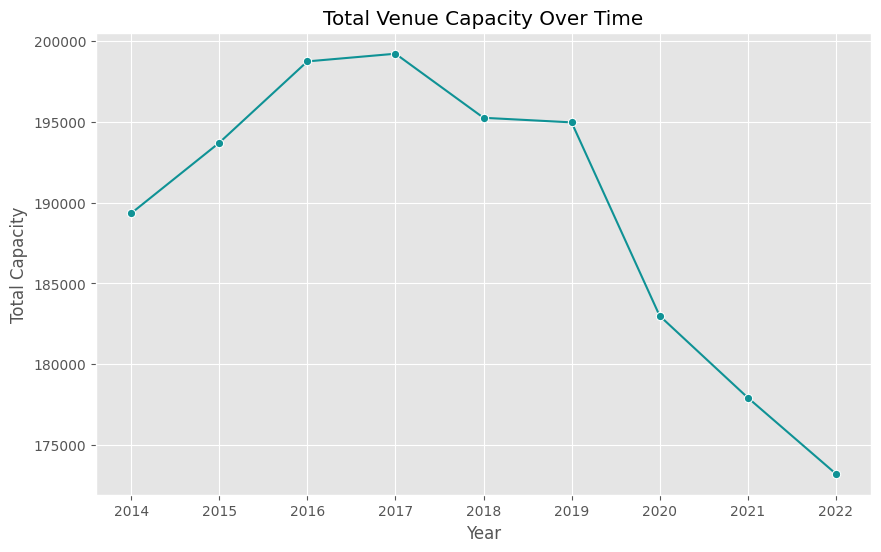

In [22]:
# Venue Capacity Over Time
capacity_trend = clue_venues.groupby('census_year')['capacity'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=capacity_trend, x='census_year', y='capacity', marker='o', color=color_d[2])
plt.title('Total Venue Capacity Over Time')
plt.xlabel('Year')
plt.ylabel('Total Capacity')
plt.grid(True)
plt.show()

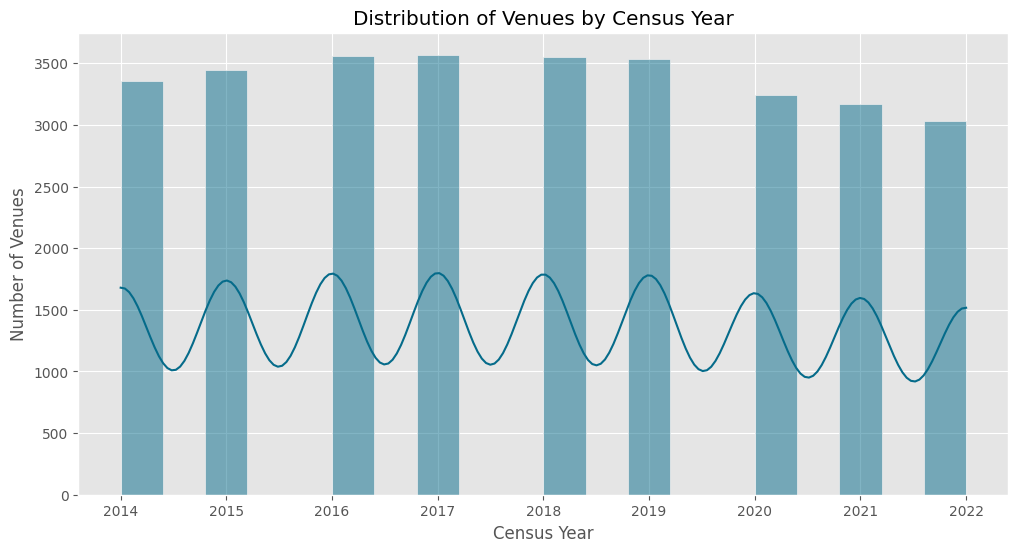

In [23]:
# Venue Distribution by Year
plt.figure(figsize=(12, 6))
sns.histplot(clue_venues['census_year'], bins=20, kde=True, color=color_d[3])
plt.title('Distribution of Venues by Census Year')
plt.xlabel('Census Year')
plt.ylabel('Number of Venues')
plt.grid(True)
plt.show()

#### Number of Venues by Trading names

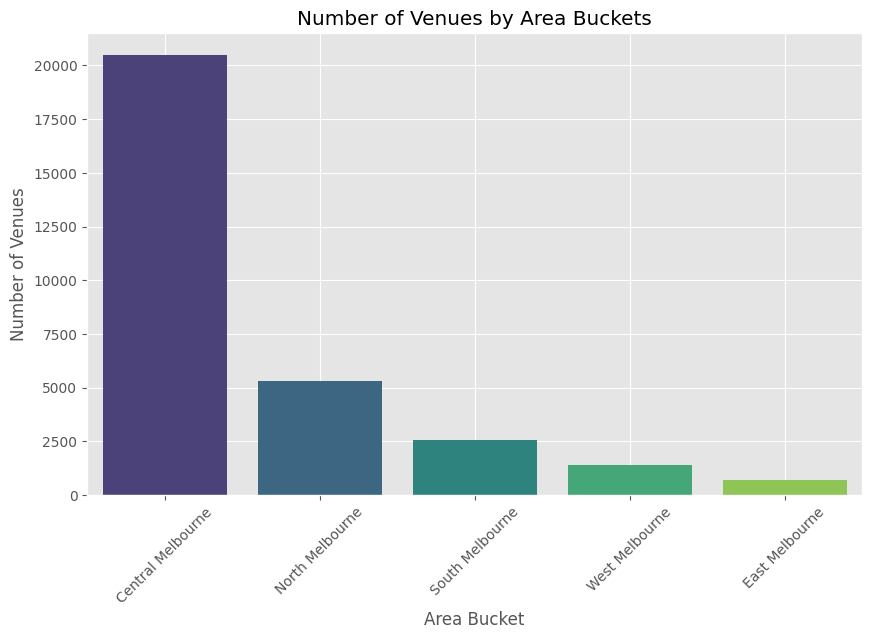

In [24]:
# Number of Venues by Trading names (using location)
area_bucket_mapping = {
    'Melbourne (CBD)': 'Central Melbourne',
    'Carlton': 'North Melbourne',
    'Parkville': 'North Melbourne',
    'North Melbourne': 'North Melbourne',
    'East Melbourne': 'East Melbourne',
    'Southbank': 'South Melbourne',
    'Melbourne (Remainder)': 'Central Melbourne',
    'South Yarra': 'South Melbourne',
    'Docklands': 'Central Melbourne',
    'West Melbourne (Residential)': 'West Melbourne',
    'Kensington': 'West Melbourne',
    'Port Melbourne': 'South Melbourne',
    'West Melbourne (Industrial)': 'West Melbourne'
}

clue_venues['area_bucket'] = clue_venues['clue_small_area'].map(area_bucket_mapping)
bucket_counts = clue_venues['area_bucket'].value_counts().reset_index()
bucket_counts.columns = ['area_bucket', 'count']

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(data=bucket_counts, x='area_bucket', y='count', palette='viridis')
plt.title('Number of Venues by Area Buckets')
plt.xlabel('Area Bucket')
plt.ylabel('Number of Venues')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

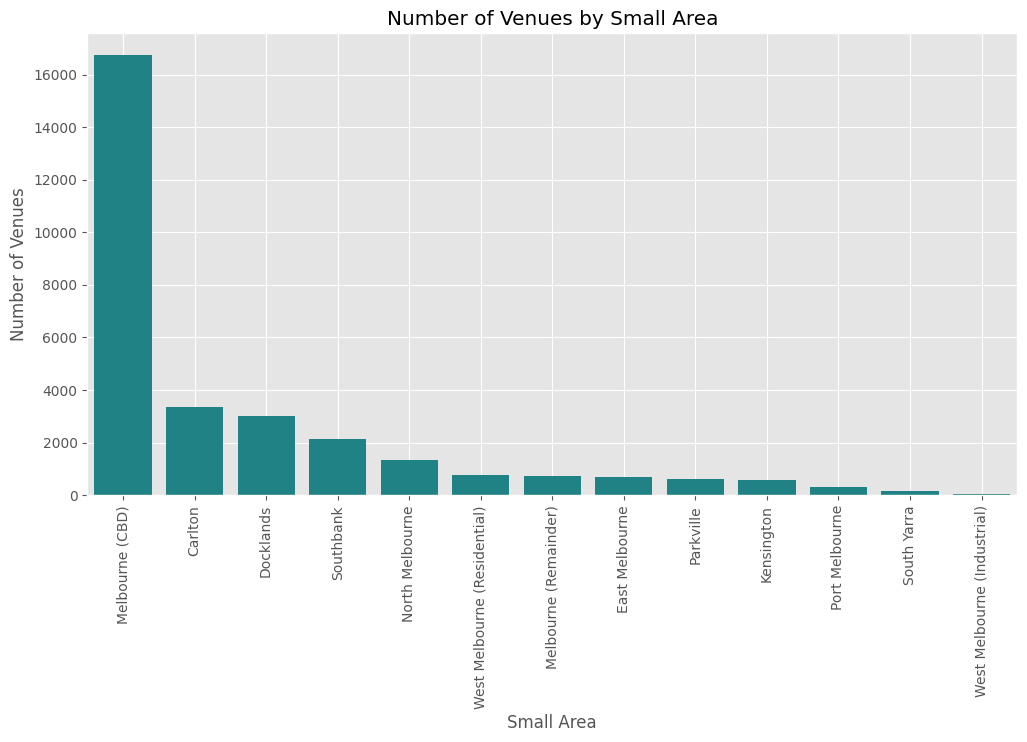

In [25]:
# Venues by Small Area
small_area_counts = clue_venues['clue_small_area'].value_counts().reset_index()
small_area_counts.columns = ['clue_small_area', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(data=small_area_counts, x='clue_small_area', y='count', color=color_d[2])
plt.title('Number of Venues by Small Area')
plt.xlabel('Small Area')
plt.ylabel('Number of Venues')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


   clue_small_area        area_bucket
0  Melbourne (CBD)  Central Melbourne
1  Melbourne (CBD)  Central Melbourne
2  Melbourne (CBD)  Central Melbourne
3  Melbourne (CBD)  Central Melbourne
4  Melbourne (CBD)  Central Melbourne
   census_year  block_id  property_id  base_property_id  \
0         2002        11       108972            108972   
1         2002        14       103172            103172   
2         2002        15       103944            103944   
3         2002        16       103938            103938   
4         2002        17       103925            103925   

                        building_address  clue_small_area     trading_name  \
0    10-22 Spencer Street MELBOURNE 3000  Melbourne (CBD)    Explorers Inn   
1  31-39 Elizabeth Street MELBOURNE 3000  Melbourne (CBD)  Connells Tavern   
2   277-279 Flinders Lane MELBOURNE 3000  Melbourne (CBD)         De Biers   
3       187 Flinders Lane MELBOURNE 3000  Melbourne (CBD)    Adelphi Hotel   
4   121-123 Flinders Lane M

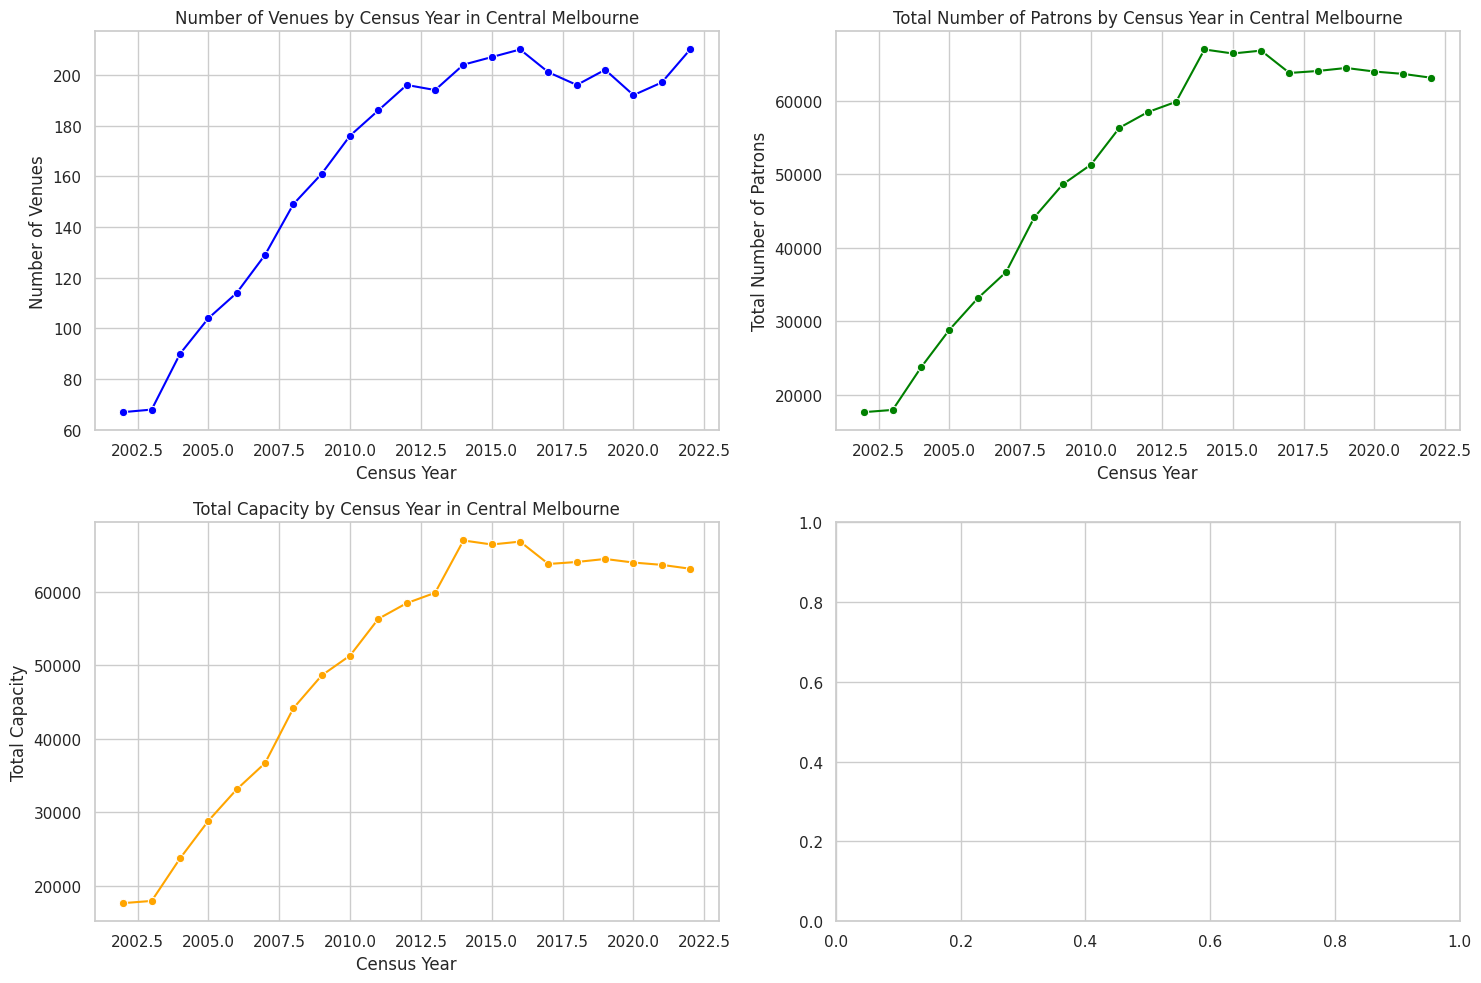

Data for North Melbourne:
    census_year  number_of_patrons  capacity
24         2002              600.0     600.0
25         2002              611.0     611.0
26         2002              200.0     200.0
27         2002              210.0     210.0
28         2002               90.0      90.0
Yearly data for North Melbourne:
   census_year  number_of_venues  total_patrons  total_capacity
0         2002                24         6092.0          6092.0
1         2003                29         7721.0          7721.0
2         2004                29         7721.0          7721.0
3         2005                32         7865.0          7865.0
4         2006                32         7865.0          7865.0


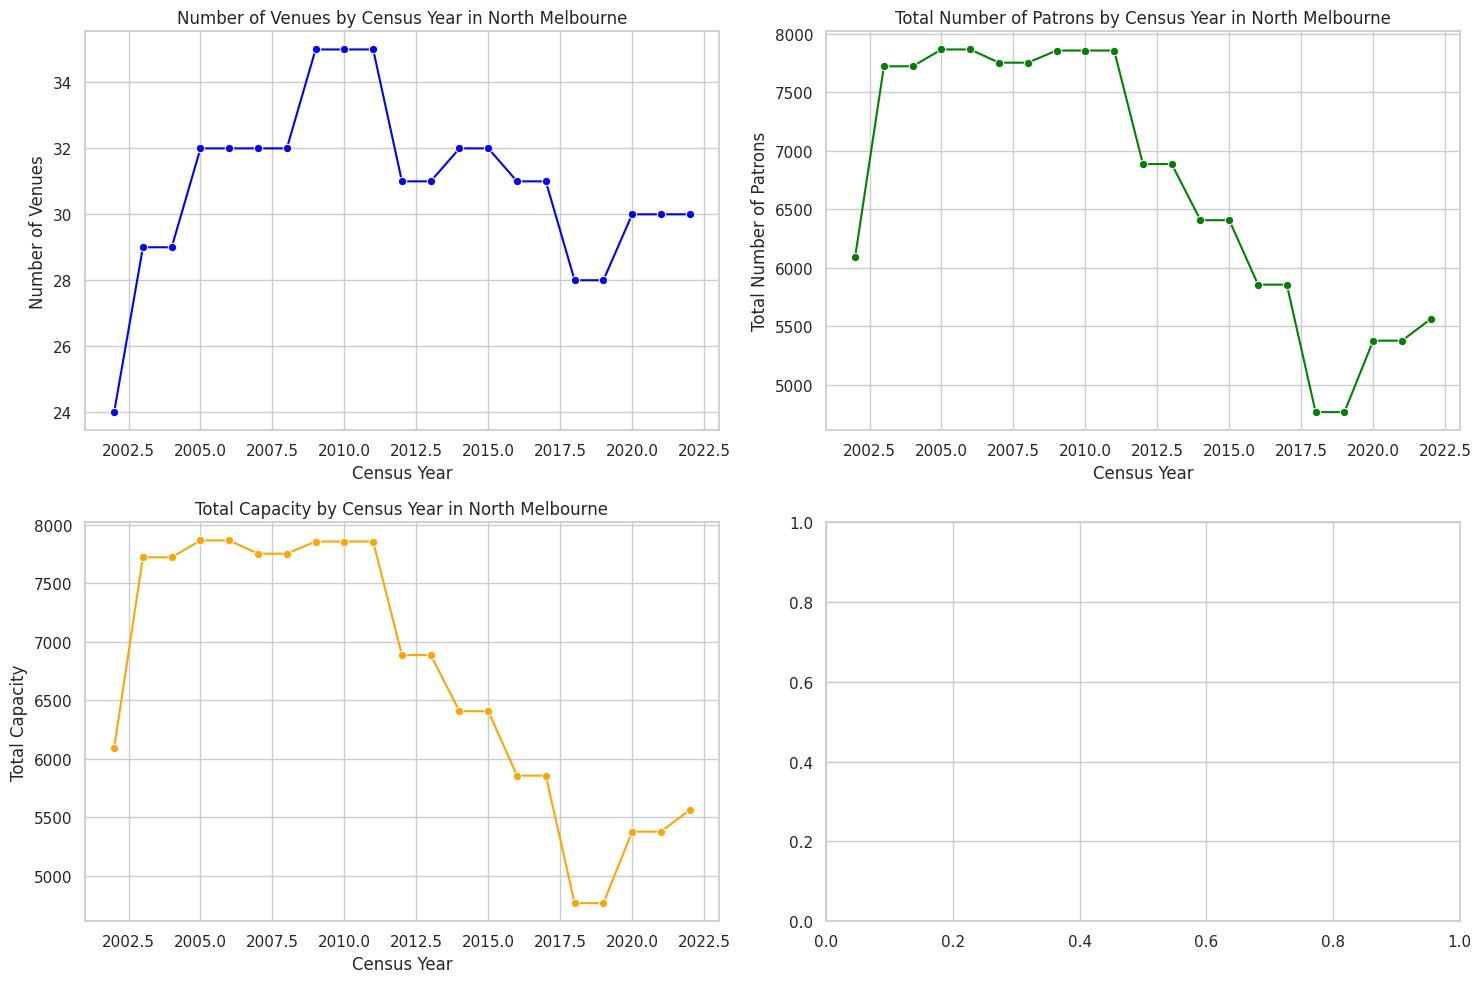

Data for East Melbourne:
     census_year  number_of_patrons  capacity
32          2002             2545.0    2545.0
64          2003             2545.0    2545.0
102         2004              144.0     144.0
103         2004             2545.0    2545.0
136         2005             2545.0    2545.0
Yearly data for East Melbourne:
   census_year  number_of_venues  total_patrons  total_capacity
0         2002                 3         2889.0          2889.0
1         2003                 3         2889.0          2889.0
2         2004                 3         2889.0          2889.0
3         2005                 2         2745.0          2745.0
4         2006                 2         2745.0          2745.0


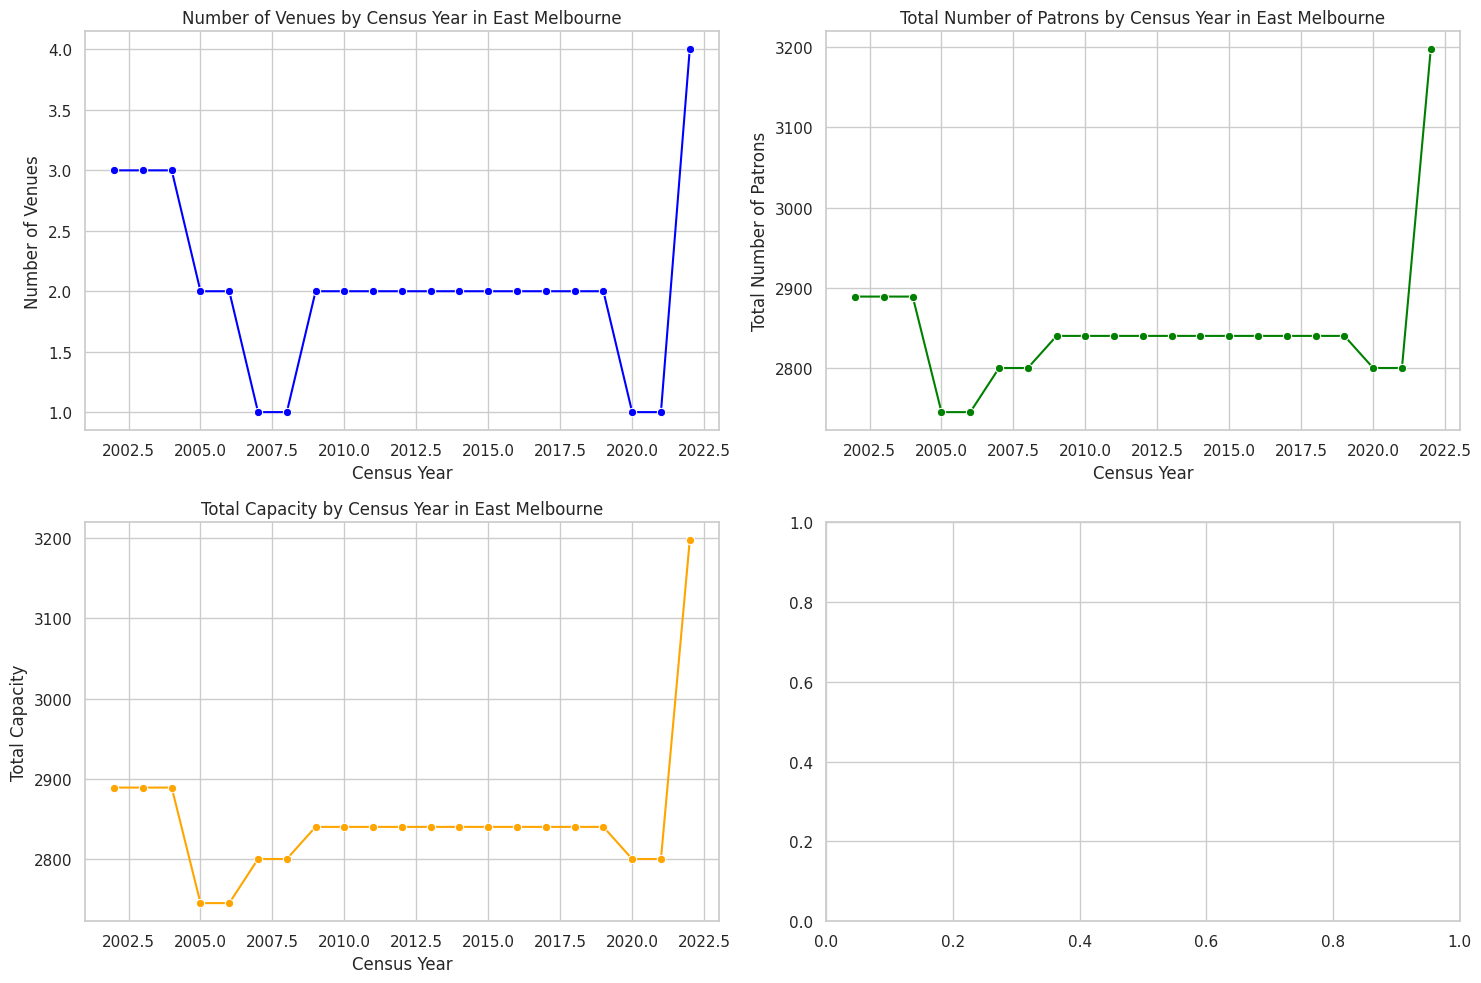

Data for South Melbourne:
     census_year  number_of_patrons  capacity
33          2002              300.0     300.0
35          2002              100.0     100.0
66          2003              300.0     300.0
104         2004              300.0     300.0
105         2004              150.0     150.0
Yearly data for South Melbourne:
   census_year  number_of_venues  total_patrons  total_capacity
0         2002                 2          400.0           400.0
1         2003                 2          400.0           400.0
2         2004                 8         1345.0          1345.0
3         2005                 8         1345.0          1345.0
4         2006                17         6539.0          6539.0


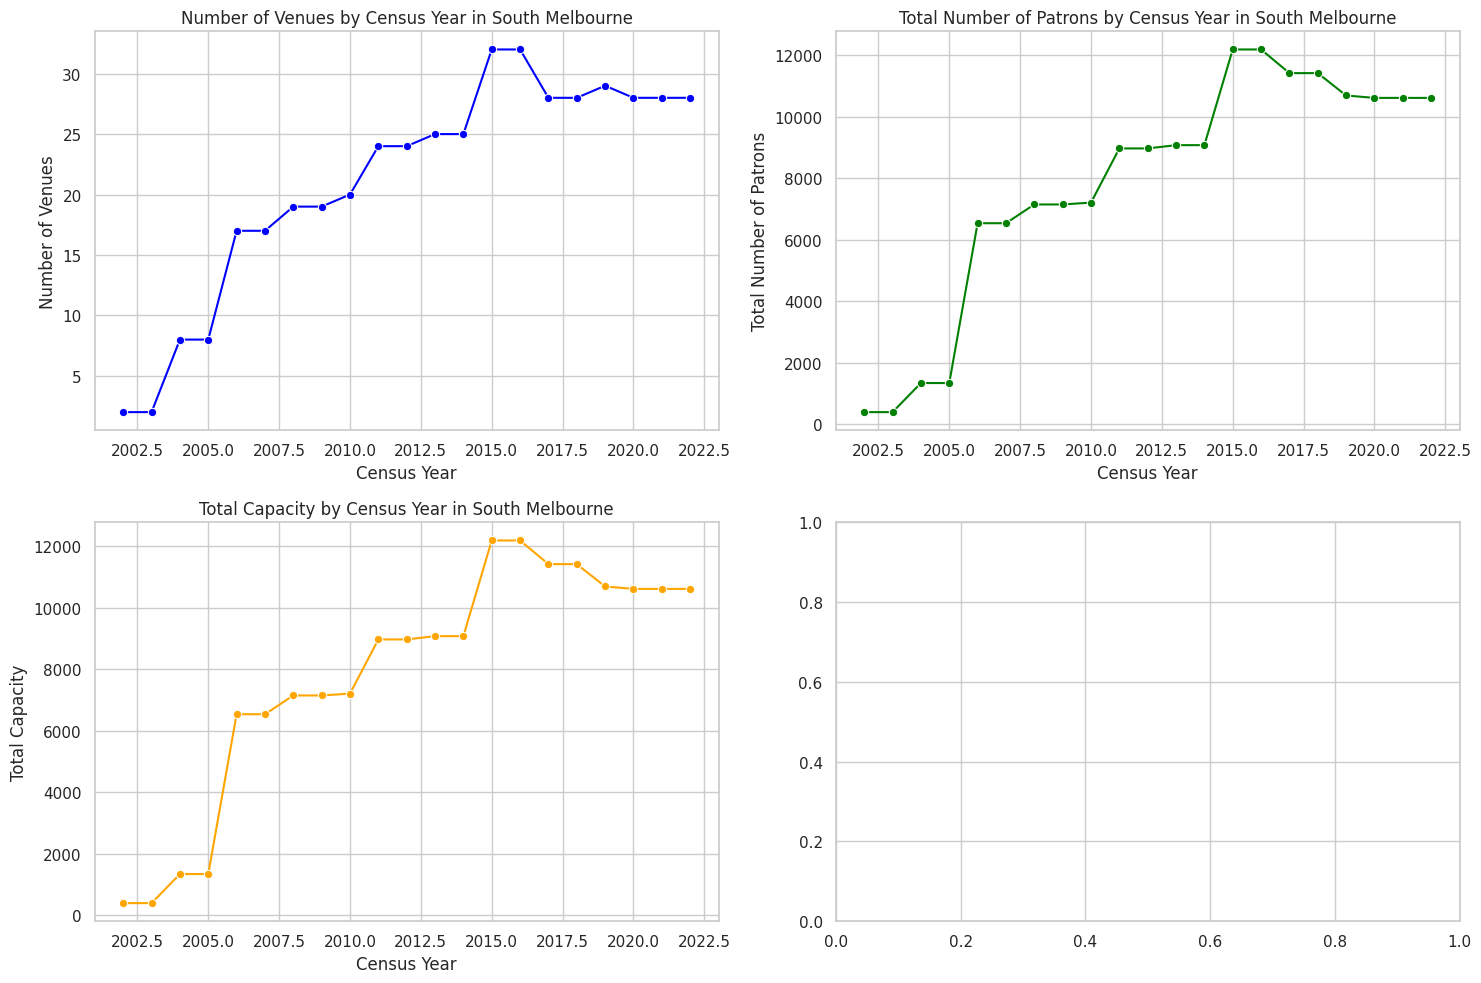

Data for West Melbourne:
     census_year  number_of_patrons  capacity
101         2004              140.0     140.0
249         2007               40.0      40.0
315         2008               40.0      40.0
446         2010               50.0      50.0
457         2010              400.0     400.0
Yearly data for West Melbourne:
   census_year  number_of_venues  total_patrons  total_capacity
0         2002                 1          140.0           140.0
1         2003                 1          140.0           140.0
2         2004                 1          140.0           140.0
3         2005                 2          180.0           180.0
4         2006                 2          180.0           180.0


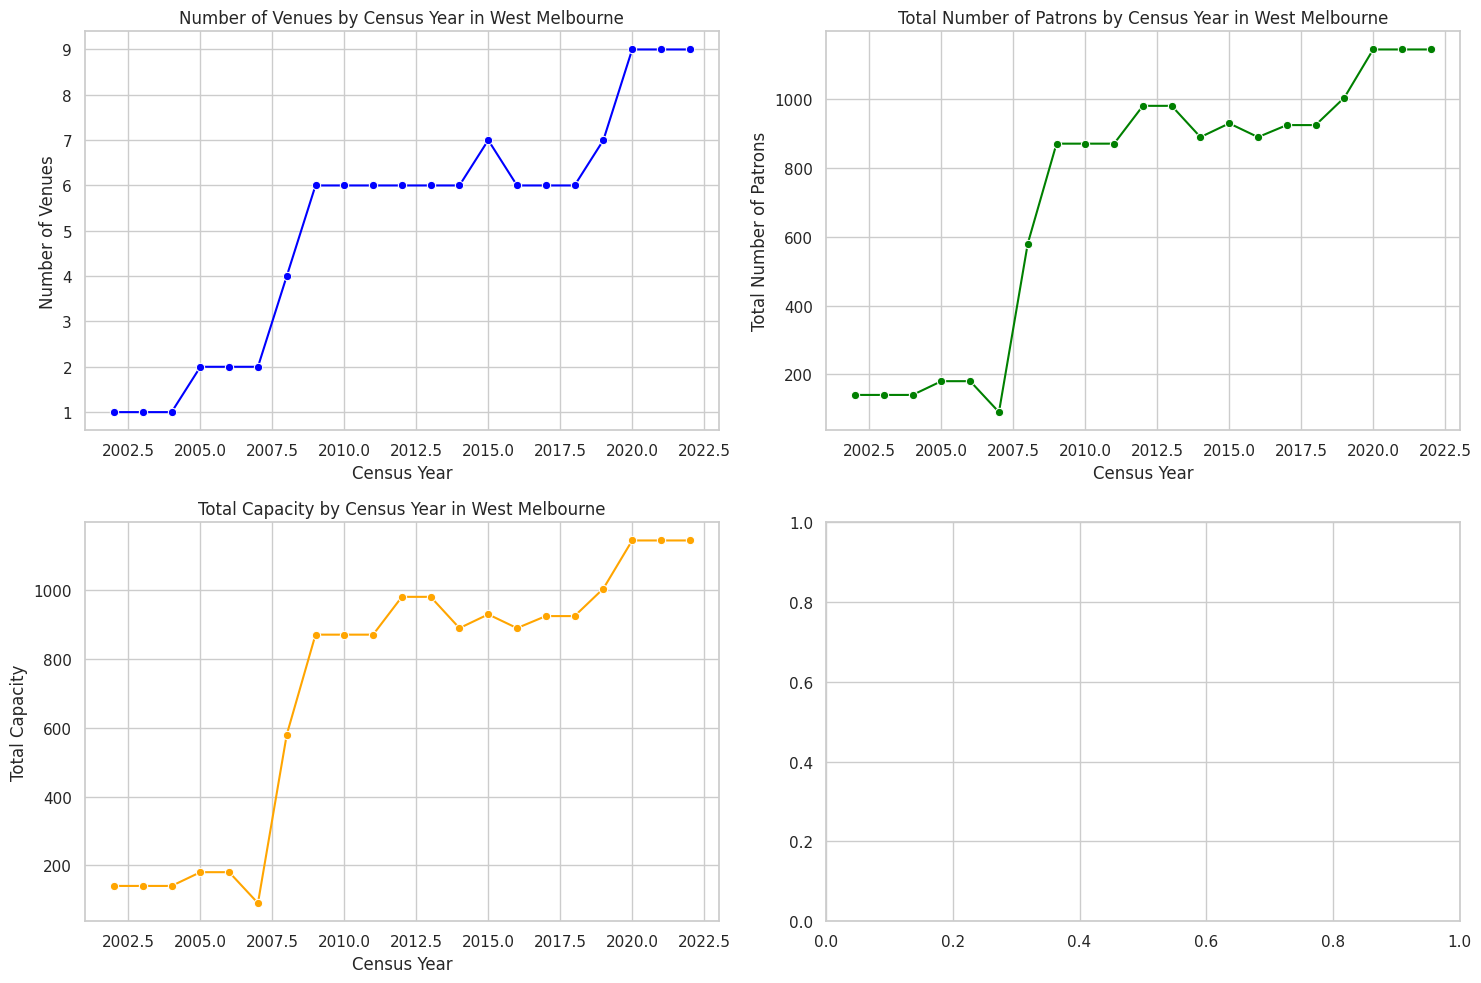

In [49]:
# Area bucket mapping
area_bucket_mapping = {
    'Melbourne (CBD)': 'Central Melbourne',
    'Carlton': 'North Melbourne',
    'Parkville': 'North Melbourne',
    'North Melbourne': 'North Melbourne',
    'East Melbourne': 'East Melbourne',
    'Southbank': 'South Melbourne',
    'Melbourne (Remainder)': 'Central Melbourne',
    'South Yarra': 'South Melbourne',
    'Docklands': 'Central Melbourne',
    'West Melbourne (Residential)': 'West Melbourne',
    'Kensington': 'West Melbourne',
    'Port Melbourne': 'South Melbourne',
    'West Melbourne (Industrial)': 'West Melbourne'
}


clue_venues['area_bucket'] = clue_venues['clue_small_area'].map(area_bucket_mapping)
print(clue_venues[['clue_small_area', 'area_bucket']].head())
filtered_clue_venues = clue_venues[clue_venues['number_of_patrons'] > 0]
print(filtered_clue_venues.head())
area_buckets = filtered_clue_venues['area_bucket'].unique()

# Plot for each area
for bucket in area_buckets:
    subset = filtered_clue_venues[filtered_clue_venues['area_bucket'] == bucket]
    print(f"Data for {bucket}:")
    print(subset[['census_year', 'number_of_patrons', 'capacity']].head())
    yearly_data = subset.groupby('census_year').agg(
        number_of_venues=('census_year', 'size'),
        total_patrons=('number_of_patrons', 'sum'),
        total_capacity=('capacity', 'sum')
    ).reset_index()
    print(f"Yearly data for {bucket}:")
    print(yearly_data.head())
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot Census
    sns.lineplot(data=yearly_data, x='census_year', y='number_of_venues', marker='o', ax=axes[0, 0], color='blue')
    axes[0, 0].set_title(f'Number of Venues by Census Year in {bucket}')
    axes[0, 0].set_xlabel('Census Year')
    axes[0, 0].set_ylabel('Number of Venues')
    axes[0, 0].grid(True)

    # Plot Patrons
    sns.lineplot(data=yearly_data, x='census_year', y='total_patrons', marker='o', ax=axes[0, 1], color='green')
    axes[0, 1].set_title(f'Total Number of Patrons by Census Year in {bucket}')
    axes[0, 1].set_xlabel('Census Year')
    axes[0, 1].set_ylabel('Total Number of Patrons')
    axes[0, 1].grid(True)

    # Plot Capacity
    sns.lineplot(data=yearly_data, x='census_year', y='total_capacity', marker='o', ax=axes[1, 0], color='orange')
    axes[1, 0].set_title(f'Total Capacity by Census Year in {bucket}')
    axes[1, 0].set_xlabel('Census Year')
    axes[1, 0].set_ylabel('Total Capacity')
    axes[1, 0].grid(True)

    plt.tight_layout()
    plt.show()


In [27]:
pd.set_option('display.max_colwidth', None)

In [28]:
# Get stats for each based on area
clue_venues['category'] = clue_venues['category'].astype(str)
clue_venues = clue_venues[clue_venues['category'] != '0']
print(clue_venues['category'].unique())

# Capacity to Seats Ratio
clue_venues['capacity_to_seats_ratio'] = clue_venues.apply(
    lambda row: row['capacity'] / row['number_of_seats'] if row['number_of_seats'] > 0 else 0,
    axis=1
)

area_buckets = clue_venues['area_bucket'].unique()
stats_dict = {} # store statistics for each area

# Statistics
for bucket in area_buckets:
    subset = clue_venues[clue_venues['area_bucket'] == bucket]
    stats = subset[['capacity', 'number_of_seats', 'capacity_to_seats_ratio']].describe().to_dict()
    stats_dict[bucket] = stats

# Create DataFrame
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index')
print(stats_df)

['Pubs, Taverns and Bars']
                                                                                                                                                      capacity  \
Central Melbourne  {'count': 20485.0, 'mean': 54.956748840615084, 'std': 127.43144116273196, 'min': 1.0, '25%': 16.0, '50%': 35.0, '75%': 70.0, 'max': 4920.0}   
West Melbourne       {'count': 1385.0, 'mean': 55.75306859205776, 'std': 294.53101197582686, 'min': 3.0, '25%': 12.0, '50%': 20.0, '75%': 36.0, 'max': 3660.0}   
North Melbourne        {'count': 5307.0, 'mean': 42.77331825890334, 'std': 47.76951096948108, 'min': 2.0, '25%': 16.0, '50%': 30.0, '75%': 50.0, 'max': 421.0}   
East Melbourne        {'count': 710.0, 'mean': 94.09014084507042, 'std': 364.81274101907843, 'min': 4.0, '25%': 15.0, '50%': 40.0, '75%': 60.0, 'max': 3240.0}   
South Melbourne      {'count': 2568.0, 'mean': 81.22858255451713, 'std': 105.46257544574564, 'min': 2.0, '25%': 26.0, '50%': 50.0, '75%': 96.0, 'max': 1000.0}   



In [29]:
# Get unique area buckets
area_buckets = clue_venues['area_bucket'].unique()
years = clue_venues['census_year'].unique()

# Initialize a dictionary to store statistics for each area and year
stats_dict_year = {}

# Collect statistics for each area bucket and year
for bucket in area_buckets:
    for year in years:
        subset = clue_venues[(clue_venues['area_bucket'] == bucket) & (clue_venues['census_year'] == year)]
        if not subset.empty:
            stats = subset[['capacity', 'number_of_seats', 'capacity_to_seats_ratio']].describe().to_dict()
            stats_dict_year[(bucket, year)] = stats

# Convert the dictionary to a multi-index DataFrame
stats_year_df = pd.DataFrame.from_dict(stats_dict_year, orient='index')
print(stats_year_df)

                                                                                                                                                          capacity  \
Central Melbourne 2017     {'count': 2402.0, 'mean': 54.90216486261449, 'std': 127.243737632375, 'min': 1.0, '25%': 16.0, '50%': 36.0, '75%': 70.0, 'max': 4920.0}   
                  2018   {'count': 2389.0, 'mean': 54.30263708664713, 'std': 126.90276450405445, 'min': 1.0, '25%': 16.0, '50%': 35.0, '75%': 68.0, 'max': 4920.0}   
                  2022   {'count': 2013.0, 'mean': 55.48534525583706, 'std': 123.60236704049983, 'min': 2.0, '25%': 16.0, '50%': 34.0, '75%': 70.0, 'max': 4920.0}   
                  2014  {'count': 2263.0, 'mean': 55.954043305346886, 'std': 131.28381459150822, 'min': 1.0, '25%': 16.0, '50%': 36.0, '75%': 70.0, 'max': 4920.0}   
                  2015  {'count': 2330.0, 'mean': 55.478969957081546, 'std': 129.97806313167106, 'min': 1.0, '25%': 16.0, '50%': 36.0, '75%': 68.0, 'max': 4920.0}   
    

   census_year  block_id  property_id  base_property_id  \
0         2002        11       108972            108972   
1         2002        14       103172            103172   
2         2002        15       103944            103944   
3         2002        16       103938            103938   
4         2002        17       103925            103925   

                        building_address  clue_small_area     trading_name  \
0    10-22 Spencer Street MELBOURNE 3000  Melbourne (CBD)    Explorers Inn   
1  31-39 Elizabeth Street MELBOURNE 3000  Melbourne (CBD)  Connells Tavern   
2   277-279 Flinders Lane MELBOURNE 3000  Melbourne (CBD)         De Biers   
3       187 Flinders Lane MELBOURNE 3000  Melbourne (CBD)    Adelphi Hotel   
4   121-123 Flinders Lane MELBOURNE 3000  Melbourne (CBD)           Velour   

                                       business_address  number_of_patrons  \
0                   10-22 Spencer Street MELBOURNE 3000               50.0   
1                   

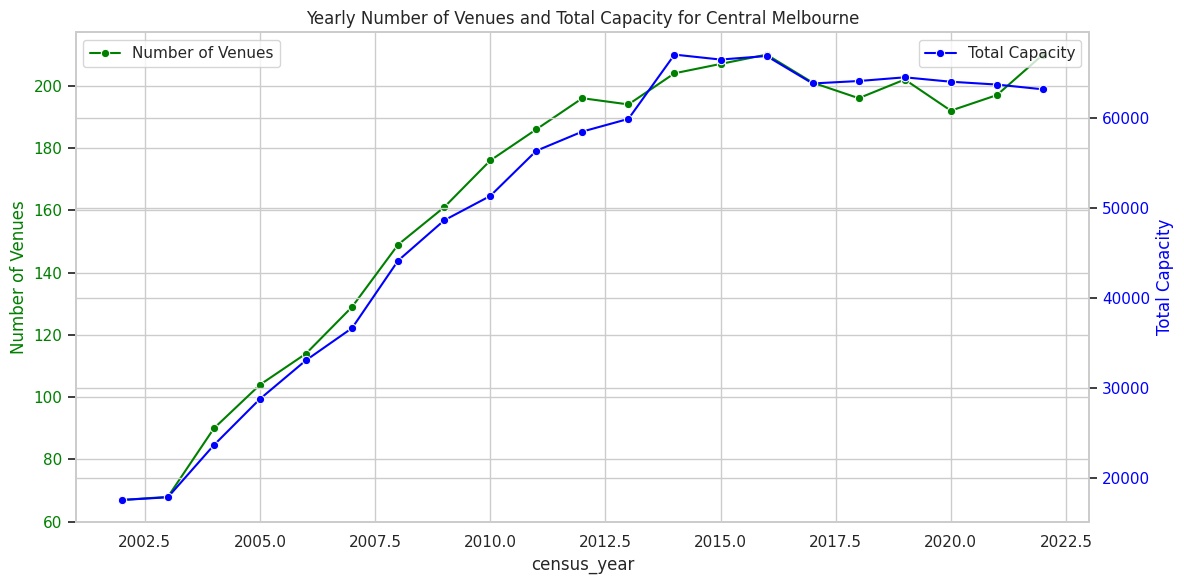

Data for North Melbourne:
    census_year  number_of_patrons  capacity
24         2002              600.0     600.0
25         2002              611.0     611.0
26         2002              200.0     200.0
27         2002              210.0     210.0
28         2002               90.0      90.0
Yearly data for North Melbourne:
   census_year  number_of_venues  total_patrons  total_capacity
0         2002                24         6092.0          6092.0
1         2003                29         7721.0          7721.0
2         2004                29         7721.0          7721.0
3         2005                32         7865.0          7865.0
4         2006                32         7865.0          7865.0


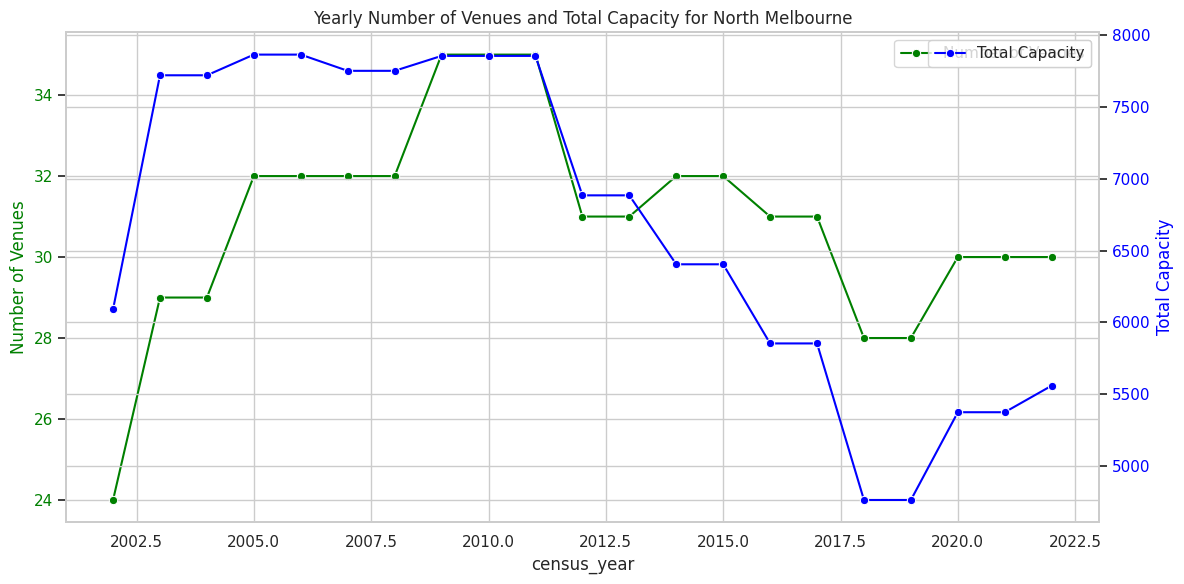

Data for East Melbourne:
     census_year  number_of_patrons  capacity
32          2002             2545.0    2545.0
64          2003             2545.0    2545.0
102         2004              144.0     144.0
103         2004             2545.0    2545.0
136         2005             2545.0    2545.0
Yearly data for East Melbourne:
   census_year  number_of_venues  total_patrons  total_capacity
0         2002                 3         2889.0          2889.0
1         2003                 3         2889.0          2889.0
2         2004                 3         2889.0          2889.0
3         2005                 2         2745.0          2745.0
4         2006                 2         2745.0          2745.0


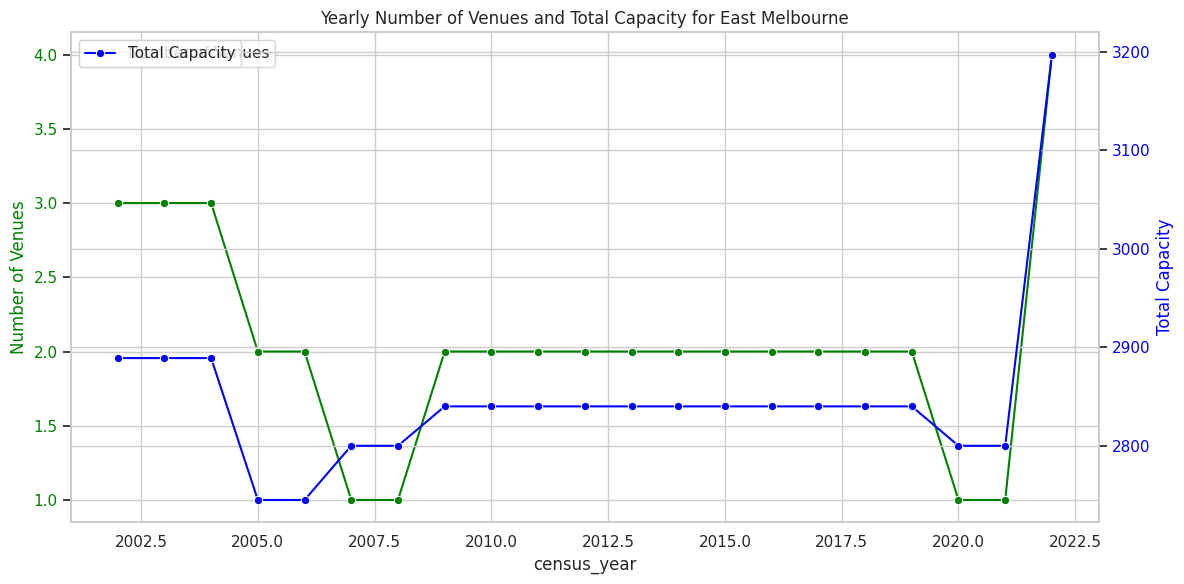

Data for South Melbourne:
     census_year  number_of_patrons  capacity
33          2002              300.0     300.0
35          2002              100.0     100.0
66          2003              300.0     300.0
104         2004              300.0     300.0
105         2004              150.0     150.0
Yearly data for South Melbourne:
   census_year  number_of_venues  total_patrons  total_capacity
0         2002                 2          400.0           400.0
1         2003                 2          400.0           400.0
2         2004                 8         1345.0          1345.0
3         2005                 8         1345.0          1345.0
4         2006                17         6539.0          6539.0


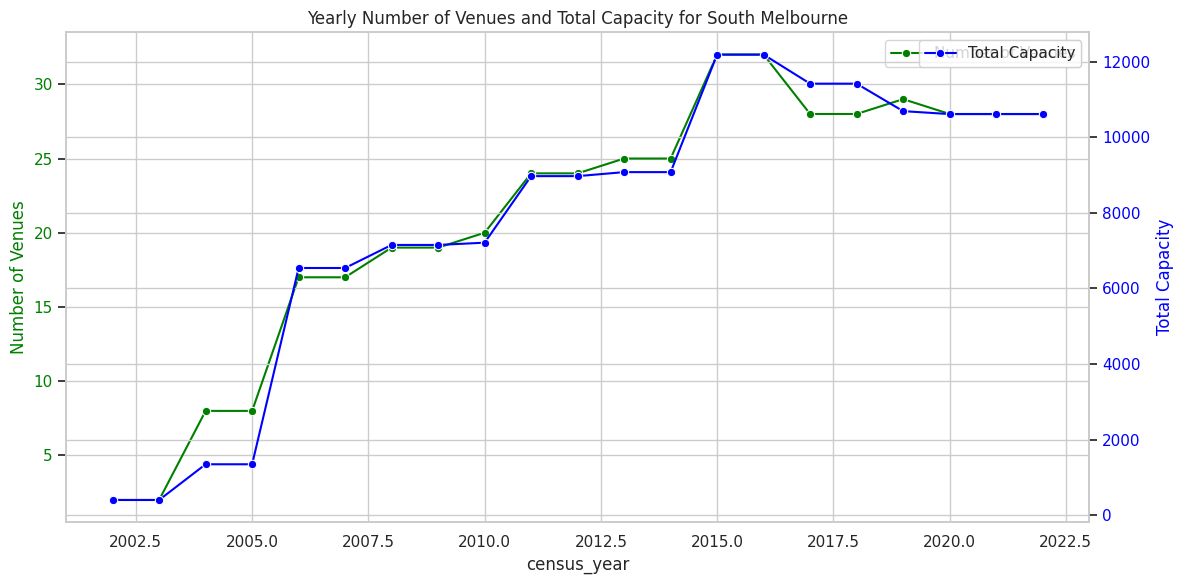

Data for West Melbourne:
     census_year  number_of_patrons  capacity
101         2004              140.0     140.0
249         2007               40.0      40.0
315         2008               40.0      40.0
446         2010               50.0      50.0
457         2010              400.0     400.0
Yearly data for West Melbourne:
   census_year  number_of_venues  total_patrons  total_capacity
0         2002                 1          140.0           140.0
1         2003                 1          140.0           140.0
2         2004                 1          140.0           140.0
3         2005                 2          180.0           180.0
4         2006                 2          180.0           180.0


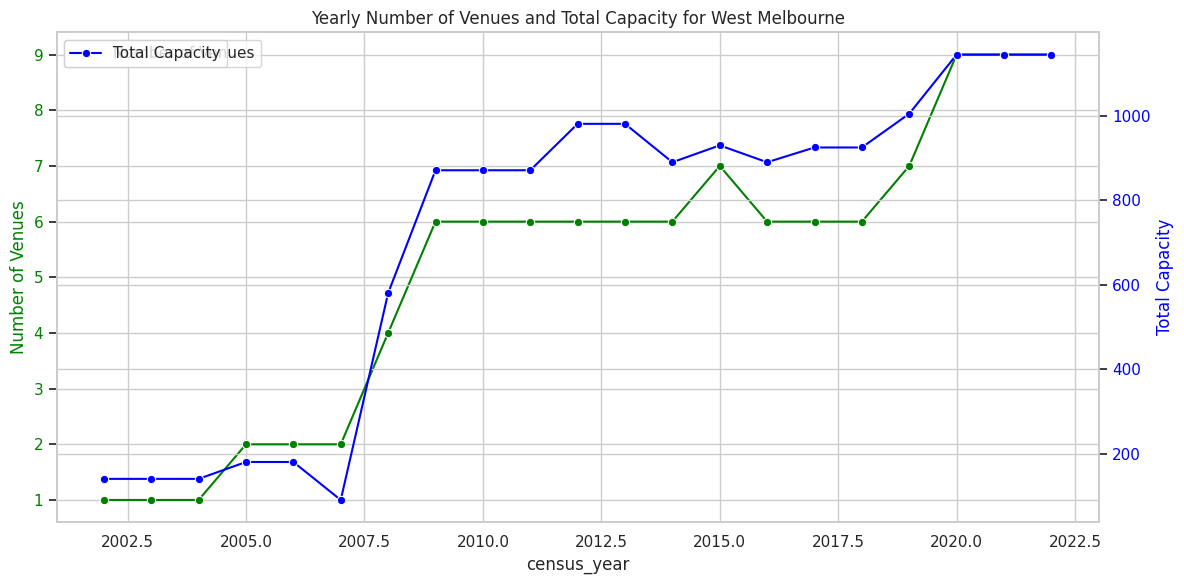

In [50]:
# Filter data
filtered_clue_venues = clue_venues[clue_venues['number_of_patrons'] > 0]
print(filtered_clue_venues.head())
area_buckets = filtered_clue_venues['area_bucket'].unique()

# Plot for each area
for bucket in area_buckets:
    bucket_data = filtered_clue_venues[filtered_clue_venues['area_bucket'] == bucket]
    print(f"Data for {bucket}:")
    print(bucket_data[['census_year', 'number_of_patrons', 'capacity']].head())
    yearly_data = bucket_data.groupby('census_year').agg(
        number_of_venues=('census_year', 'size'),
        total_patrons=('number_of_patrons', 'sum'),
        total_capacity=('capacity', 'sum')
    ).reset_index()
    print(f"Yearly data for {bucket}:")
    print(yearly_data.head())

    fig, ax1 = plt.subplots(figsize=(12, 6))

    sns.lineplot(data=yearly_data, x='census_year', y='number_of_venues', marker='o', ax=ax1, label='Number of Venues', color='green')
    ax1.set_ylabel('Number of Venues', color='green')
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.set_title(f'Yearly Number of Venues and Total Capacity for {bucket}')

    ax2 = ax1.twinx()
    sns.lineplot(data=yearly_data, x='census_year', y='total_capacity', marker='o', ax=ax2, label='Total Capacity', color='blue')
    ax2.set_ylabel('Total Capacity', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    fig.tight_layout()
    plt.show()

In [37]:
# Max and Min years for each area
for bucket in area_buckets:
    bucket_data = clue_venues[clue_venues['area_bucket'] == bucket]

    total_capacity_per_year = bucket_data.groupby('census_year')['capacity'].sum()
    venue_count_per_year = bucket_data.groupby('census_year').size()
    max_capacity_year = total_capacity_per_year.idxmax()
    min_capacity_year = total_capacity_per_year.idxmin()
    max_count_year = venue_count_per_year.idxmax()
    min_count_year = venue_count_per_year.idxmin()

    print(f"Statistics for {bucket}:")
    print(f"  Maximum Capacity Year: {max_capacity_year}, Capacity: {total_capacity_per_year[max_capacity_year]}")
    print(f"  Minimum Capacity Year: {min_capacity_year}, Capacity: {total_capacity_per_year[min_capacity_year]}")
    print(f"  Maximum Venue Count Year: {max_count_year}, Count: {venue_count_per_year[max_count_year]}")
    print(f"  Minimum Venue Count Year: {min_count_year}, Count: {venue_count_per_year[min_count_year]}")
    print("\n")

Statistics for Central Melbourne:
  Maximum Capacity Year: 2016, Capacity: 132040.0
  Minimum Capacity Year: 2022, Capacity: 111692.0
  Maximum Venue Count Year: 2017, Count: 2402
  Minimum Venue Count Year: 2022, Count: 2013


Statistics for West Melbourne:
  Maximum Capacity Year: 2015, Capacity: 8898.0
  Minimum Capacity Year: 2022, Capacity: 8056.0
  Maximum Venue Count Year: 2015, Count: 168
  Minimum Venue Count Year: 2022, Count: 127


Statistics for North Melbourne:
  Maximum Capacity Year: 2016, Capacity: 27255.0
  Minimum Capacity Year: 2020, Capacity: 23871.0
  Maximum Venue Count Year: 2016, Count: 633
  Minimum Venue Count Year: 2020, Count: 547


Statistics for East Melbourne:
  Maximum Capacity Year: 2016, Capacity: 7754.0
  Minimum Capacity Year: 2022, Capacity: 6748.0
  Maximum Venue Count Year: 2016, Count: 84
  Minimum Venue Count Year: 2022, Count: 64


Statistics for South Melbourne:
  Maximum Capacity Year: 2019, Capacity: 24182.0
  Minimum Capacity Year: 2014, Ca

### Venue Trends Yearly
#### https://seaborn.pydata.org/generated/seaborn.scatterplot.html
- Venue Distribution by Year
- Capacity and Census Year
- Distribution by Geographic Location
- Venues by Small Area

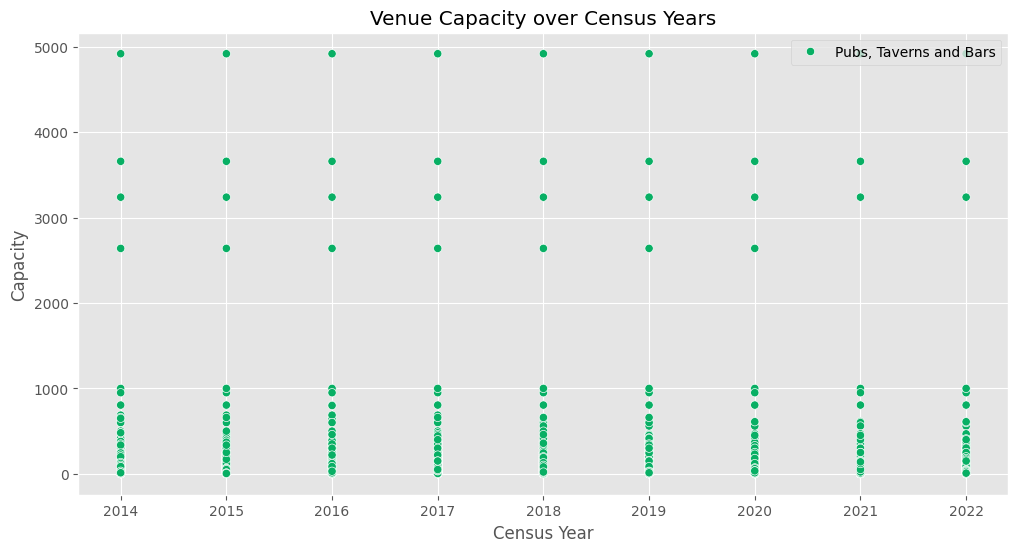

In [32]:
# Venue Distribution by Year
plt.figure(figsize=(12, 6))
sns.set_palette(sns.color_palette(color_d))
sns.scatterplot(data=clue_venues, x='census_year', y='capacity', hue='category', color="color_d")
plt.title('Venue Capacity over Census Years')
plt.xlabel('Census Year')
plt.ylabel('Capacity')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Prediction 2023 to 2030

   clue_small_area        area_bucket
0  Melbourne (CBD)  Central Melbourne
1  Melbourne (CBD)  Central Melbourne
2  Melbourne (CBD)  Central Melbourne
3  Melbourne (CBD)  Central Melbourne
4  Melbourne (CBD)  Central Melbourne
   census_year  block_id  property_id  base_property_id  \
0         2002        11       108972            108972   
1         2002        14       103172            103172   
2         2002        15       103944            103944   
3         2002        16       103938            103938   
4         2002        17       103925            103925   

                        building_address  clue_small_area     trading_name  \
0    10-22 Spencer Street MELBOURNE 3000  Melbourne (CBD)    Explorers Inn   
1  31-39 Elizabeth Street MELBOURNE 3000  Melbourne (CBD)  Connells Tavern   
2   277-279 Flinders Lane MELBOURNE 3000  Melbourne (CBD)         De Biers   
3       187 Flinders Lane MELBOURNE 3000  Melbourne (CBD)    Adelphi Hotel   
4   121-123 Flinders Lane M

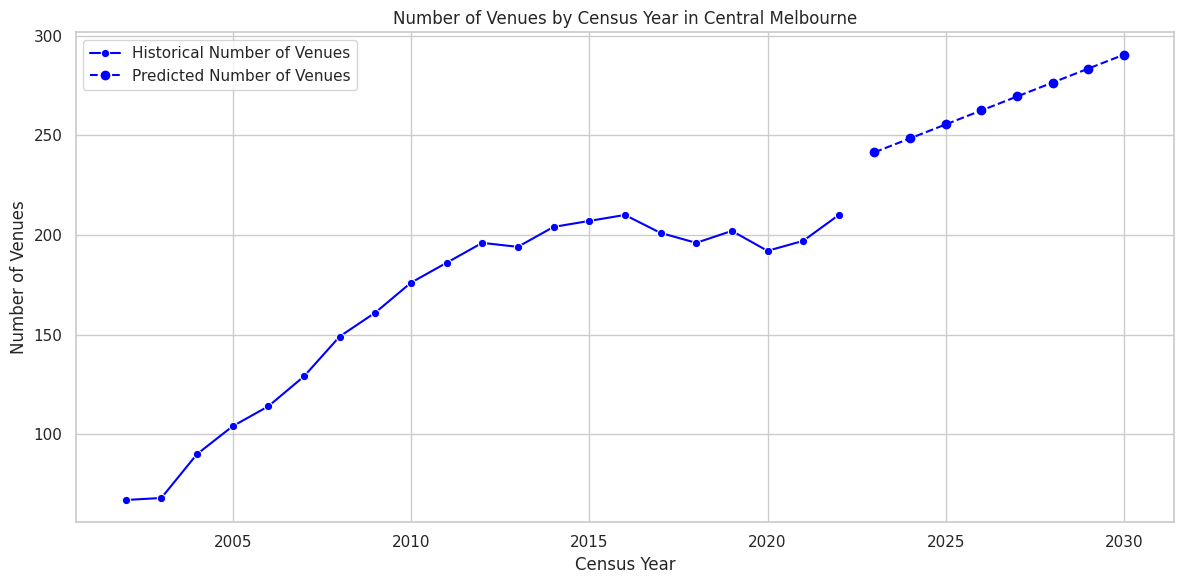

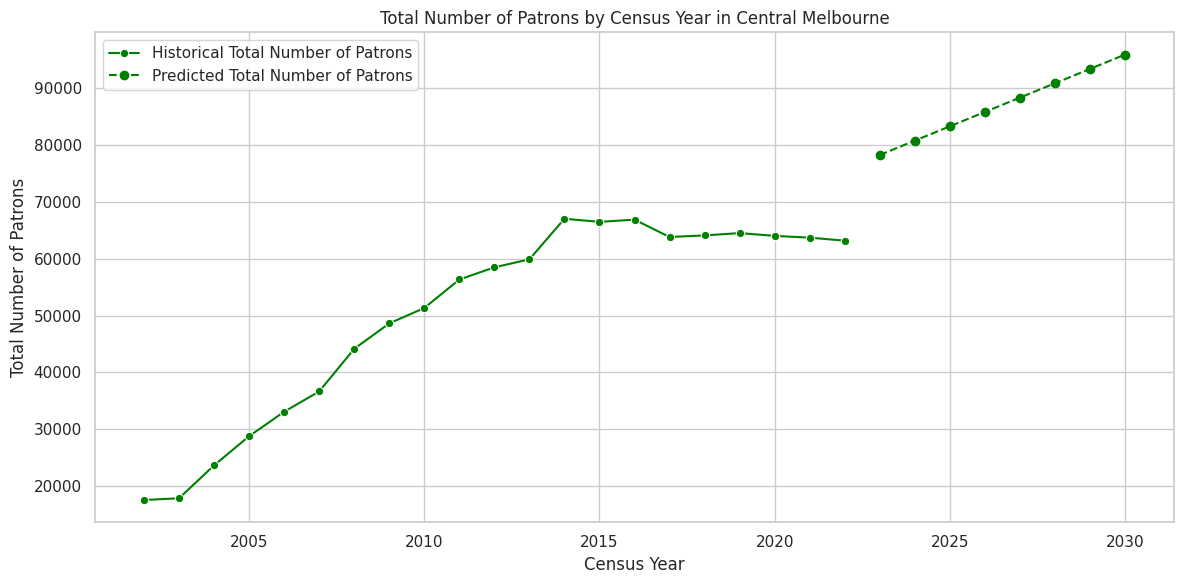

Data for North Melbourne:
    census_year  number_of_patrons  capacity
24         2002              600.0     600.0
25         2002              611.0     611.0
26         2002              200.0     200.0
27         2002              210.0     210.0
28         2002               90.0      90.0
Yearly data for North Melbourne:
   census_year  number_of_venues  total_patrons  total_capacity
0         2002                24         6092.0          6092.0
1         2003                29         7721.0          7721.0
2         2004                29         7721.0          7721.0
3         2005                32         7865.0          7865.0
4         2006                32         7865.0          7865.0
Correlation for North Melbourne:
                   number_of_patrons  capacity
number_of_patrons                1.0       1.0
capacity                         1.0       1.0



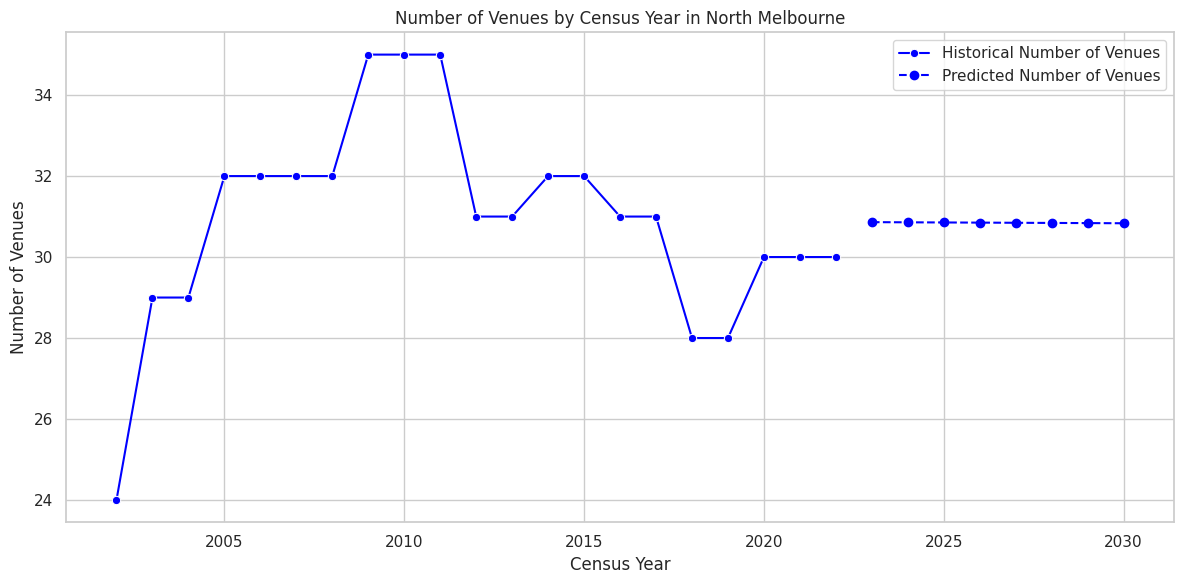

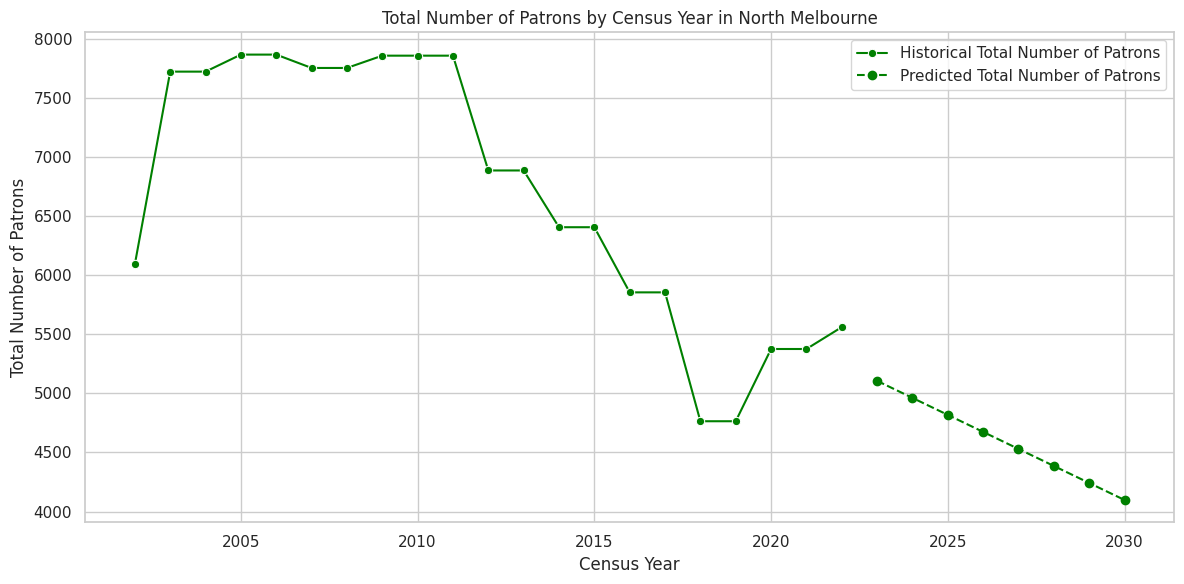

Data for East Melbourne:
     census_year  number_of_patrons  capacity
32          2002             2545.0    2545.0
64          2003             2545.0    2545.0
102         2004              144.0     144.0
103         2004             2545.0    2545.0
136         2005             2545.0    2545.0
Yearly data for East Melbourne:
   census_year  number_of_venues  total_patrons  total_capacity
0         2002                 3         2889.0          2889.0
1         2003                 3         2889.0          2889.0
2         2004                 3         2889.0          2889.0
3         2005                 2         2745.0          2745.0
4         2006                 2         2745.0          2745.0
Correlation for East Melbourne:
                   number_of_patrons  capacity
number_of_patrons                1.0       1.0
capacity                         1.0       1.0



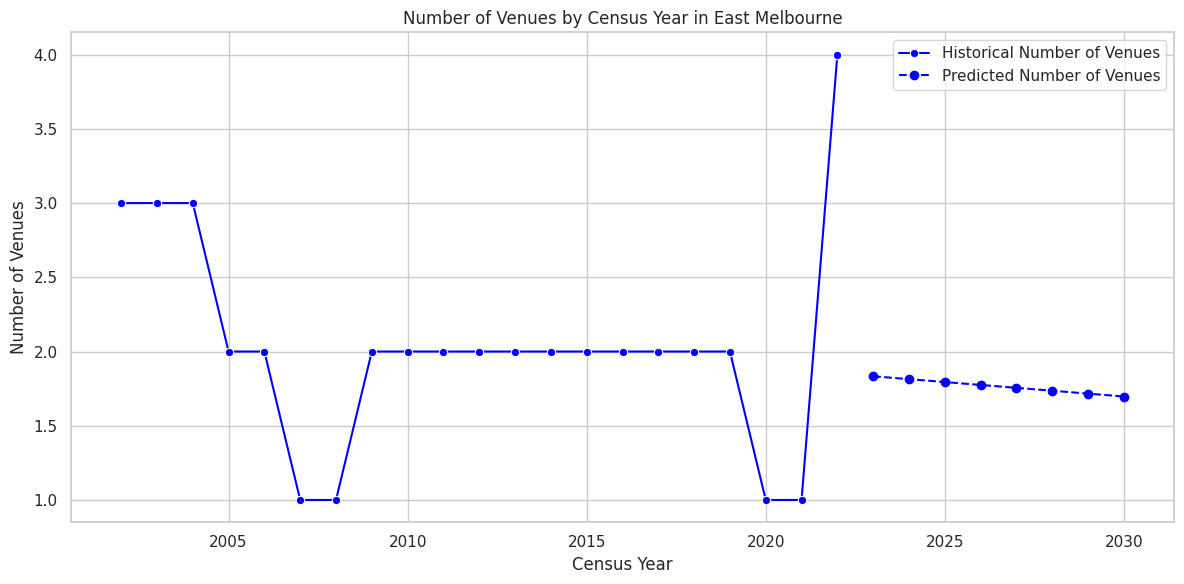

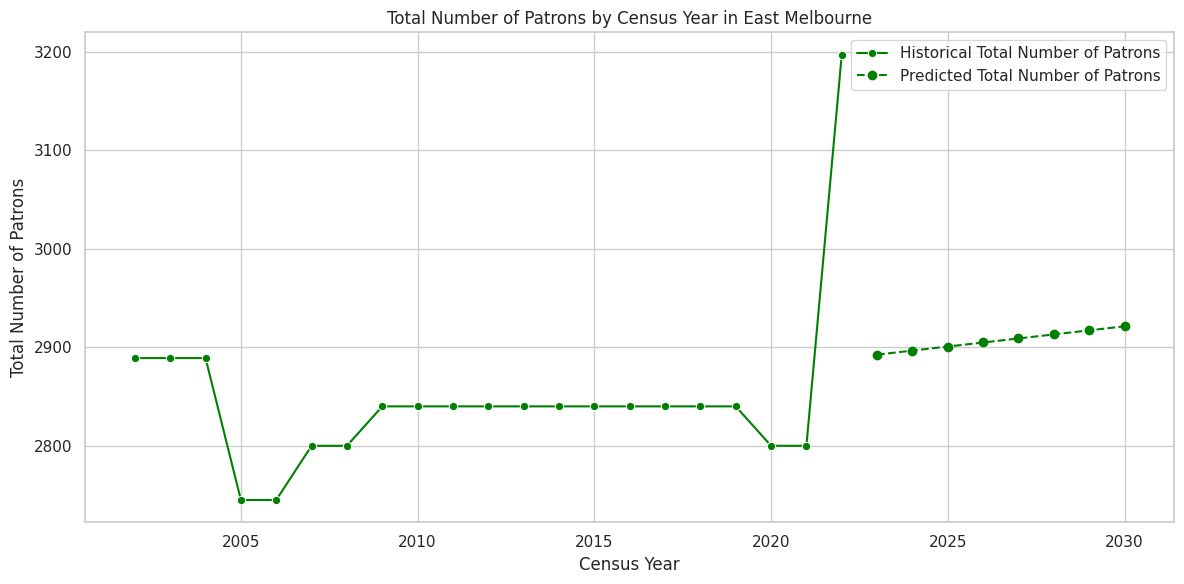

Data for South Melbourne:
     census_year  number_of_patrons  capacity
33          2002              300.0     300.0
35          2002              100.0     100.0
66          2003              300.0     300.0
104         2004              300.0     300.0
105         2004              150.0     150.0
Yearly data for South Melbourne:
   census_year  number_of_venues  total_patrons  total_capacity
0         2002                 2          400.0           400.0
1         2003                 2          400.0           400.0
2         2004                 8         1345.0          1345.0
3         2005                 8         1345.0          1345.0
4         2006                17         6539.0          6539.0
Correlation for South Melbourne:
                   number_of_patrons  capacity
number_of_patrons                1.0       1.0
capacity                         1.0       1.0



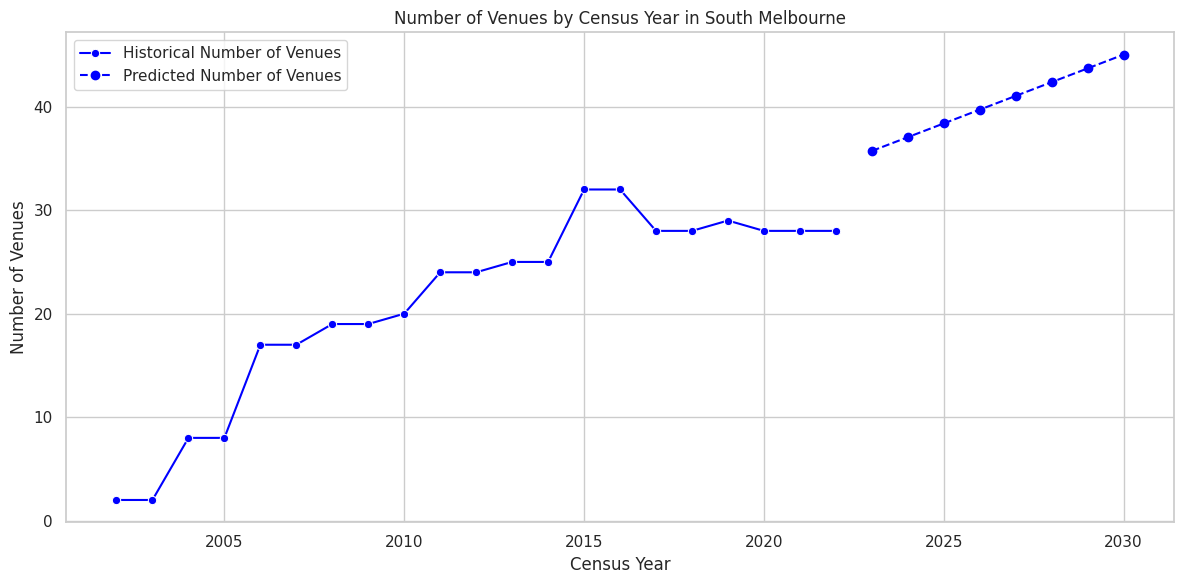

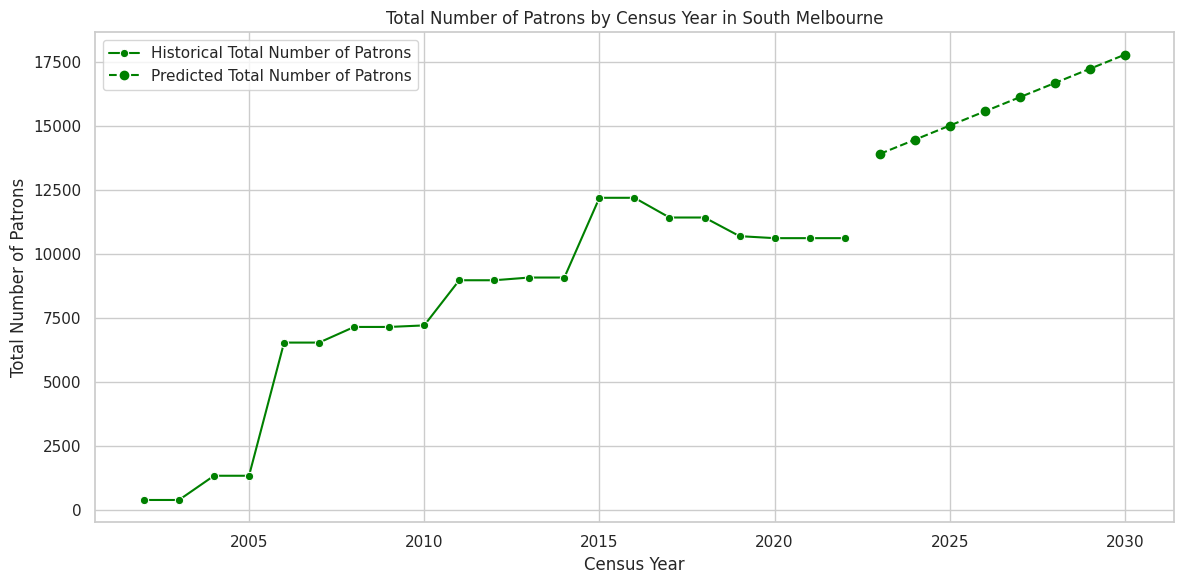

Data for West Melbourne:
     census_year  number_of_patrons  capacity
101         2004              140.0     140.0
249         2007               40.0      40.0
315         2008               40.0      40.0
446         2010               50.0      50.0
457         2010              400.0     400.0
Yearly data for West Melbourne:
   census_year  number_of_venues  total_patrons  total_capacity
0         2002                 1          140.0           140.0
1         2003                 1          140.0           140.0
2         2004                 1          140.0           140.0
3         2005                 2          180.0           180.0
4         2006                 2          180.0           180.0
Correlation for West Melbourne:
                   number_of_patrons  capacity
number_of_patrons                1.0       1.0
capacity                         1.0       1.0



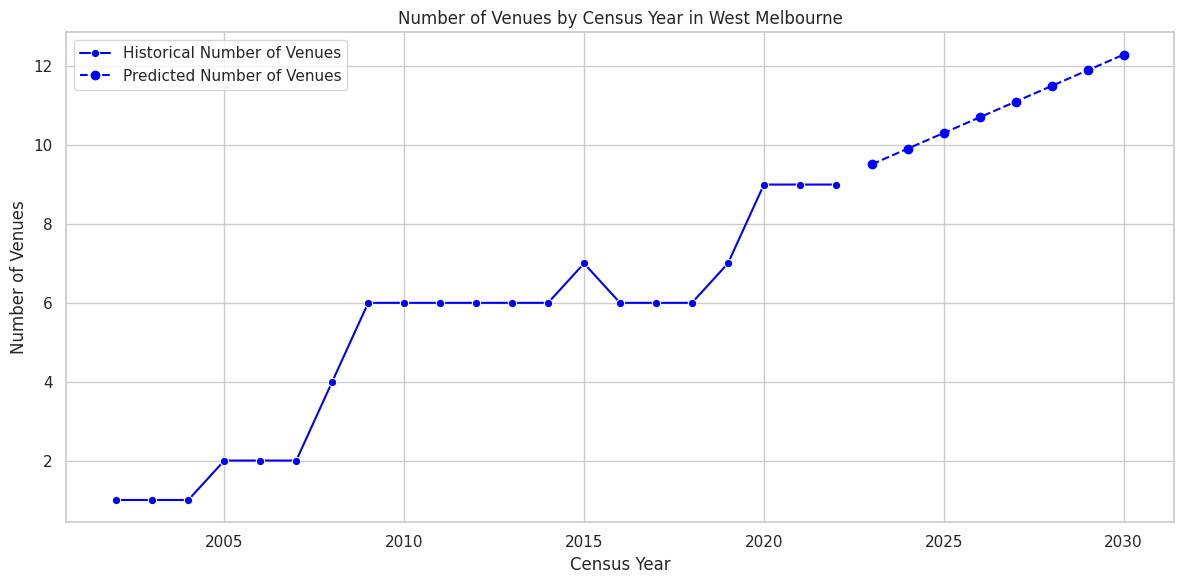

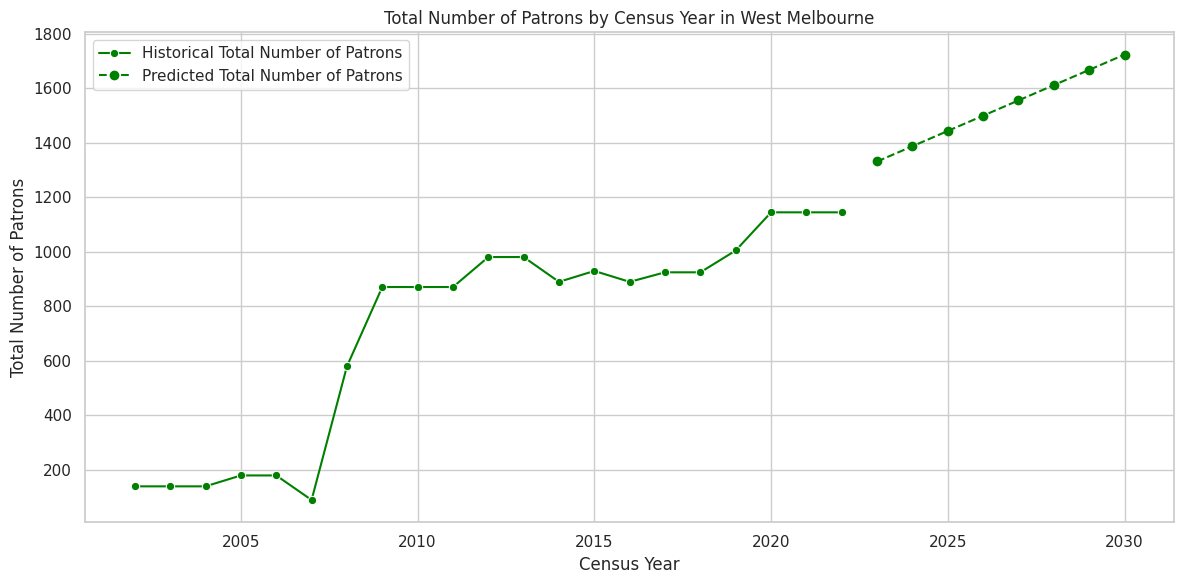

In [40]:
# Prediction
from sklearn.linear_model import LinearRegression
sns.set(style="whitegrid")

# Ensure that the area_bucket column is created
area_bucket_mapping = {
    'Melbourne (CBD)': 'Central Melbourne',
    'Carlton': 'North Melbourne',
    'Parkville': 'North Melbourne',
    'North Melbourne': 'North Melbourne',
    'East Melbourne': 'East Melbourne',
    'Southbank': 'South Melbourne',
    'Melbourne (Remainder)': 'Central Melbourne',
    'South Yarra': 'South Melbourne',
    'Docklands': 'Central Melbourne',
    'West Melbourne (Residential)': 'West Melbourne',
    'Kensington': 'West Melbourne',
    'Port Melbourne': 'South Melbourne',
    'West Melbourne (Industrial)': 'West Melbourne'
}

clue_venues['area_bucket'] = clue_venues['clue_small_area'].map(area_bucket_mapping)
print(clue_venues[['clue_small_area', 'area_bucket']].head())
filtered_clue_venues = clue_venues[clue_venues['number_of_patrons'] > 0]
print(filtered_clue_venues.head())
area_buckets = filtered_clue_venues['area_bucket'].unique()
future_years = np.array(range(2023, 2031)).reshape(-1, 1)  # Predict 2023 to 2030

# Plot
for bucket in area_buckets:
    subset = filtered_clue_venues[filtered_clue_venues['area_bucket'] == bucket]
    print(f"Data for {bucket}:")
    print(subset[['census_year', 'number_of_patrons', 'capacity']].head())

    # Aggregate census year
    yearly_data = subset.groupby('census_year').agg(
        number_of_venues=('census_year', 'size'),
        total_patrons=('number_of_patrons', 'sum'),
        total_capacity=('capacity', 'sum')
    ).reset_index()
    print(f"Yearly data for {bucket}:")
    print(yearly_data.head())

    # Correlation number_of_patrons & capacity
    correlation = subset[['number_of_patrons', 'capacity']].corr()
    print(f"Correlation for {bucket}:\n{correlation}\n")
    X = yearly_data['census_year'].values.reshape(-1, 1)
    y_venues = yearly_data['number_of_venues'].values
    y_patrons = yearly_data['total_patrons'].values

    # Fit Linear Regression (LR)
    model_venues = LinearRegression() # Venues
    model_venues.fit(X, y_venues)
    predicted_venues = model_venues.predict(future_years)
    model_patrons = LinearRegression() # Patrons
    model_patrons.fit(X, y_patrons)
    predicted_patrons = model_patrons.predict(future_years)

    # Plot 1
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=yearly_data, x='census_year', y='number_of_venues', marker='o', label='Historical Number of Venues', color='blue')
    plt.plot(future_years, predicted_venues, marker='o', linestyle='--', label='Predicted Number of Venues', color='blue')
    plt.title(f'Number of Venues by Census Year in {bucket}')
    plt.xlabel('Census Year')
    plt.ylabel('Number of Venues')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=yearly_data, x='census_year', y='total_patrons', marker='o', label='Historical Total Number of Patrons', color='green')
    plt.plot(future_years, predicted_patrons, marker='o', linestyle='--', label='Predicted Total Number of Patrons', color='green')
    plt.title(f'Total Number of Patrons by Census Year in {bucket}')
    plt.xlabel('Census Year')
    plt.ylabel('Total Number of Patrons')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


<div class="usecase-section-header">References</div>

City of Melbourne Open Data Team, 2016 - 2022,'Bar, tavern, pub patron capacity 2020', City of Melbourne, date retrieved 26 Nov 2022, <https://data.melbourne.vic.gov.au/explore/dataset/bars-and-pubs-with-patron-capacity/information/>

City of Melbourne Open Data Team, 2015 - 2022,'Cafe, restaurant, bistro seats 2020', City of Melbourne, date retrieved 26 Nov 2022, <https://data.melbourne.vic.gov.au/explore/dataset/cafes-and-restaurants-with-seating-capacity/information/>

City of Melbourne Open Data Team, 2021 - 2022,'City Activities and Planned Works', City of Melbourne, date retrieved 26 Nov 2022, <https://data.melbourne.vic.gov.au/explore/dataset/city-activities-and-planned-works/information/?disjunctive.classification&disjunctive.small_area>

City of Melbourne Open Data Team, 2014 - 2021,'Pedestrian Counting System - Monthly (counts per hour)', City of Melbourne, date retrieved 03 Dec 2022, <https://melbournetestbed.opendatasoft.com/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/>

City of Melbourne Open Data Team, 2018 - 2021,'Pedestrian Counting System - Sensor Locations', City of Melbourne, date retrieved 03 Dec 2022, <https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-sensor-locations/information/>

City of Melbourne Open Data Team, 2021 - 2022,'City of Melbourne Population Forecasts by Small Area 2021-2041', City of Melbourne, date retrieved 15 Dec 2022, <https://data.melbourne.vic.gov.au/explore/dataset/city-of-melbourne-population-forecasts-by-small-area-2020-2040/information/>
